In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 1
!hostname
!pwd

v011.ib.bridges2.psc.edu
/ocean/projects/asc170022p/mtragoza/mre-pinn/notebooks


In [2]:
import sys, os, pathlib
import numpy as np
import xarray as xr
import torch
torch.backends.cudnn.enabled = True
import matplotlib.pyplot as plt
import seaborn as sns

os.environ['DDEBACKEND'] = 'pytorch'
import deepxde

sys.path.append('..')
%aimport mre_pinn

torch.cuda.is_available()

Using backend: pytorch



True

In [3]:
%autoreload

cohort = mre_pinn.data.PatientCohort(patient_ids=['0006'], xarray_dir='../data/NAFLD')
#cohort = mre_pinn.data.PatientCohort.from_file('../data/NAFLD/NAFLD_2022-11-7.xarrays', xarray_dir='../data/NAFLD')
#cohort.create_xarrays()
#cohort.save_xarrays()
#cohort.metadata
cohort.load_xarrays()
cohort.eval_baseline()

  0%|          | 0/1 [00:00<?, ?it/s]Loading ../data/NAFLD/0006/t1_pre_in.nc
Loading ../data/NAFLD/0006/t1_pre_water.nc
Loading ../data/NAFLD/0006/t1_pre_out.nc
Loading ../data/NAFLD/0006/t1_pre_fat.nc
Loading ../data/NAFLD/0006/t2.nc
Loading ../data/NAFLD/0006/mre_raw.nc
Loading ../data/NAFLD/0006/wave.nc
Loading ../data/NAFLD/0006/mre.nc
Loading ../data/NAFLD/0006/anat_mask.nc
Loading ../data/NAFLD/0006/mre_mask.nc
  0%|          | 0/1 [00:00<?, ?it/s]

  return key in self.data

  return key in self.data

  return key in self.data

  return key in self.data

  return key in self.data



100%|██████████| 1/1 [00:01<00:00,  1.15s/it]


In [4]:
pde = mre_pinn.pde.WaveEquation.from_name('helmholtz', rho=1e3, omega=60, detach=True)
pde

In [5]:
%autoreload

pino = mre_pinn.model.pino.HyperCNN(
    n_channels_in=1,
    n_channels_block=16,
    n_conv_per_block=1,
    n_conv_blocks=5,
    width_factor=2,
    activ_fn='g',
    n_latent=128,
    n_pinn_layers=2,
    n_pinn_hidden=1024,
    u_omega=160,
    u_scale=1e2,
    u_loc=0,
    mu_omega=160,
    mu_scale=1e3,
    mu_loc=0,
    skip_connect=True,
    dense=True,
    parallel=False
)
pino

HyperCNN(
  (u_cnn): CNN(
    (conv_in): Conv3d(1, 16, kernel_size=(1, 1, 1), stride=(1, 1, 1))
    (conv_block0): ConvBlock(
      (conv0): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    )
    (pool0): AvgPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0)
    (conv_block1): ConvBlock(
      (conv0): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    )
    (pool1): AvgPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0)
    (conv_block2): ConvBlock(
      (conv0): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    )
    (pool2): AvgPool3d(kernel_size=(2, 2, 1), stride=(2, 2, 1), padding=0)
    (conv_block3): ConvBlock(
      (conv0): Conv3d(128, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    )
    (pool3): AvgPool3d(kernel_size=(2, 2, 1), stride=(2, 2, 1), padding=0)
    (conv_block4): ConvBlock(
      (conv0): Conv3d(256, 256, kernel_size=(3, 3, 3), stride=(1, 1,

In [6]:
%autoreload

model = mre_pinn.training.PINOModel(
    cohort, pino, pde,
    loss_weights=[1e-2, 1e-3, 1e-17],
    batch_size=1,
    n_points=16384,
    pde_warmup_iters=5000,
    pde_step_iters=5000
)
model.compile(
    optimizer='adam',
    lr=1e-5,
    loss=mre_pinn.training.losses.msae_loss
)   
test_eval = mre_pinn.testing.TestEvaluator(test_every=100, interact=True)

Precomputing tensors
Compiling model...
'compile' took 0.000255 s



In [7]:
%%time
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = False
model.benchmark(10)

# iterations: 10
Data time/iter:  0.0215s (2.23%)
Model time/iter: 0.9269s (96.05%)
Loss time/iter:  0.0166s (1.72%)
Total time/iter: 0.9650s
Total time: 9.6502s
1k iters time: 16.08m
10k iters time: 160.84m
100k iters time: 26.81h
CPU times: user 1.91 s, sys: 1.12 s, total: 3.03 s
Wall time: 9.65 s


Training model...

Step      Train loss                        Test loss                         Test metric
0         [1.07e+04, 1.25e+05, 0.00e+00]    [1.06e+04, 1.24e+05, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



<IPython.core.display.Javascript object>


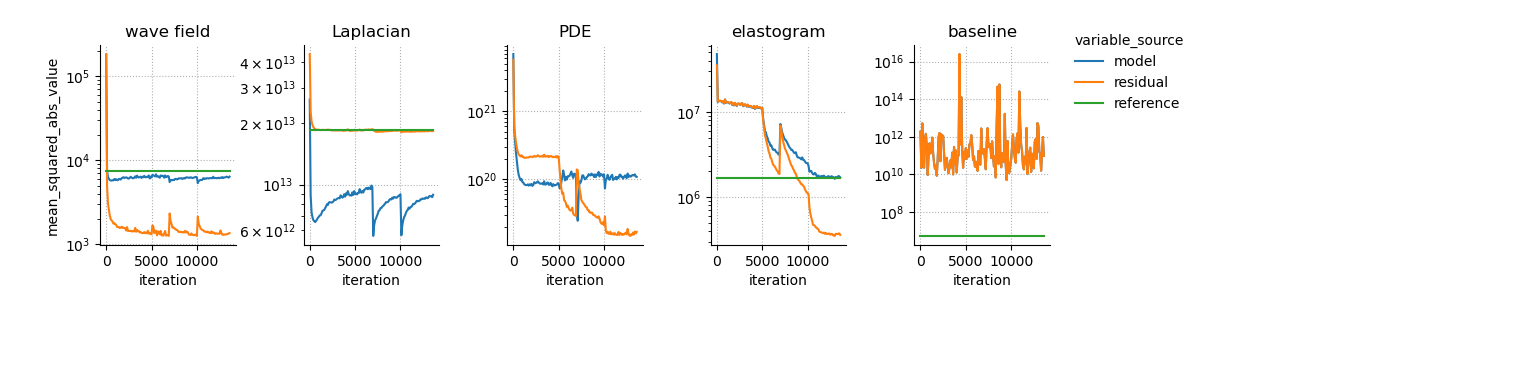

<IPython.core.display.Javascript object>


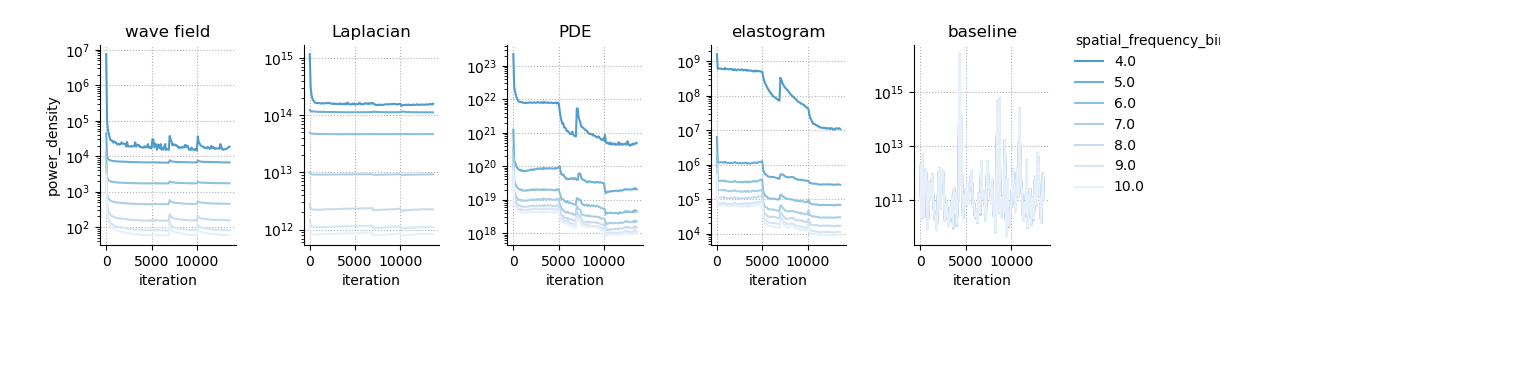

<IPython.core.display.Javascript object>


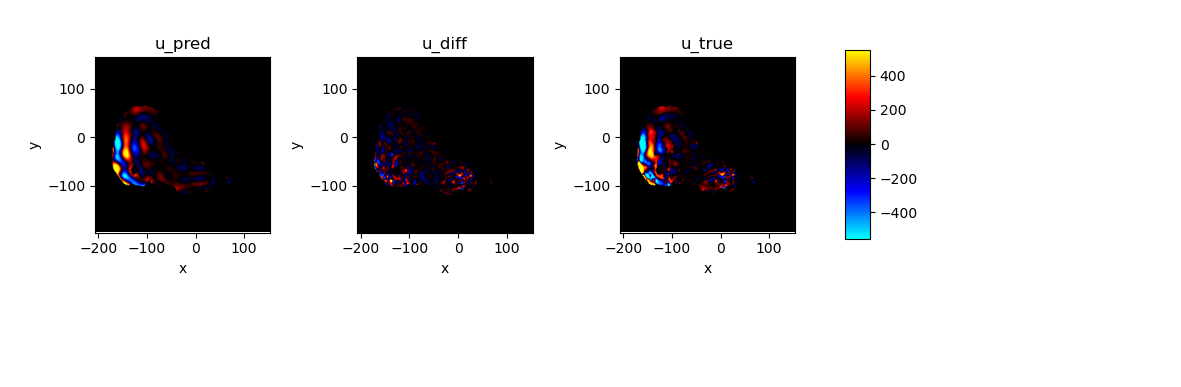

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

<IPython.core.display.Javascript object>


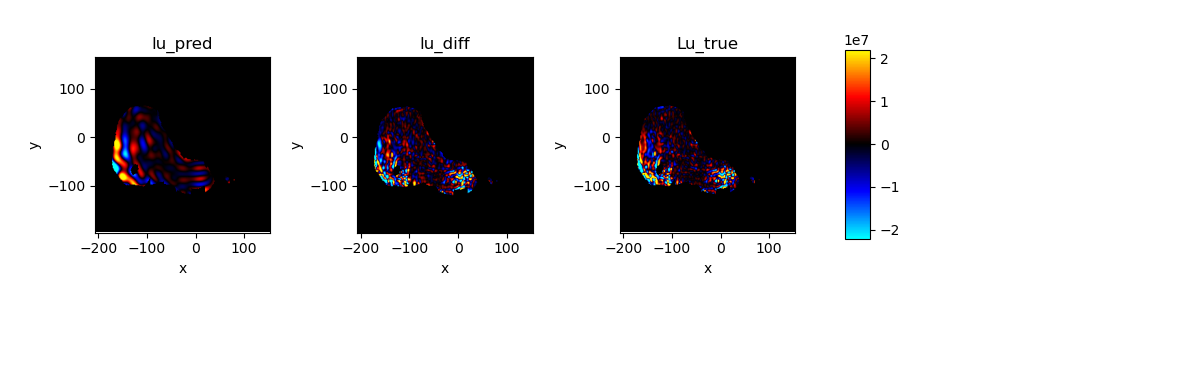

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

<IPython.core.display.Javascript object>


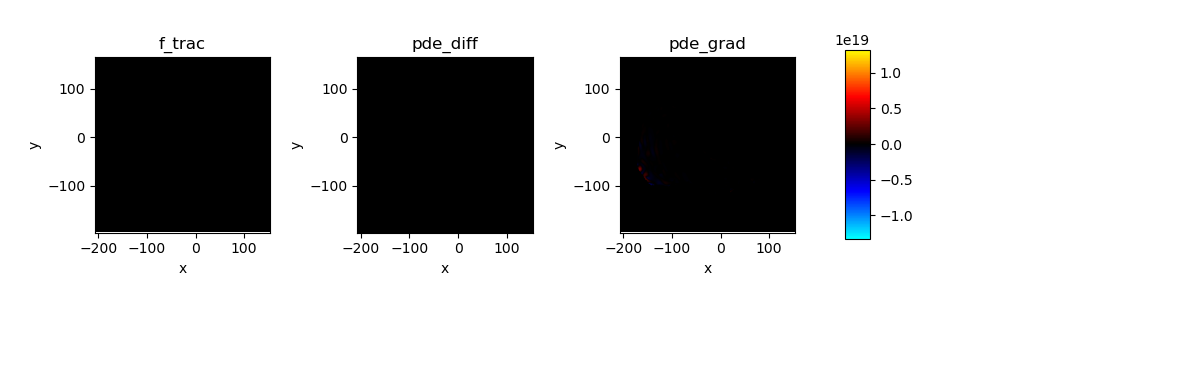

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

<IPython.core.display.Javascript object>


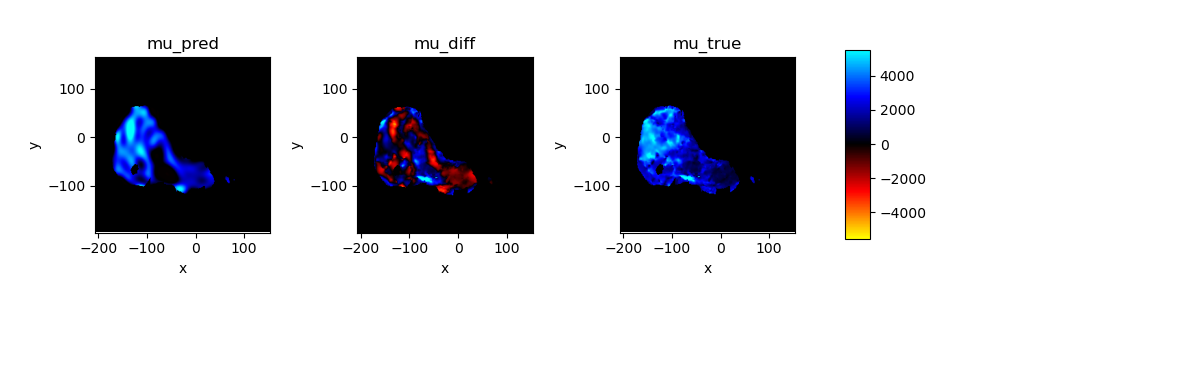

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

<IPython.core.display.Javascript object>


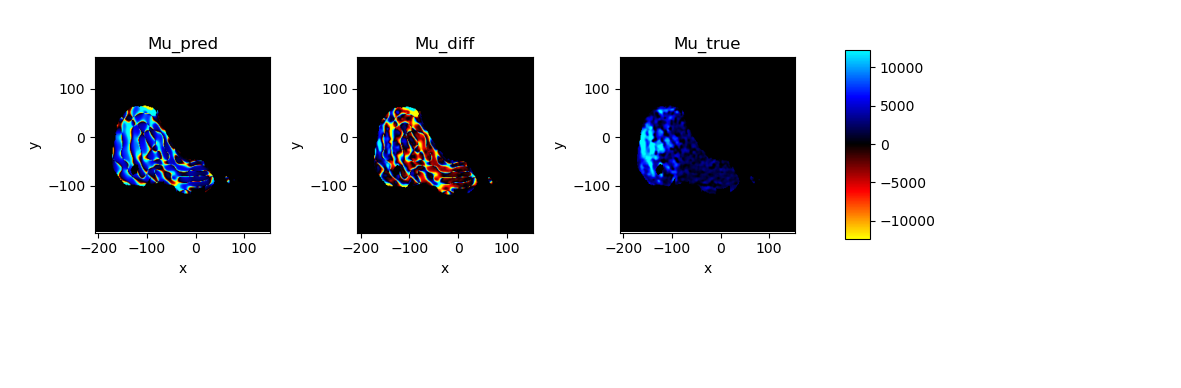

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

Time spent testing: 13.9048 (13.83%)
10        [5.65e+03, 4.97e+03, 0.00e+00]    [5.70e+03, 4.83e+03, 0.00e+00]    []  
20        [2.40e+03, 1.50e+02, 0.00e+00]    [2.43e+03, 1.48e+02, 0.00e+00]    []  
30        [1.29e+03, 9.39e+01, 0.00e+00]    [1.29e+03, 1.00e+02, 0.00e+00]    []  
40        [8.50e+02, 1.41e+00, 0.00e+00]    [8.53e+02, 1.18e+00, 0.00e+00]    []  
50        [6.01e+02, 1.34e-03, 0.00e+00]    [6.01e+02, 1.36e+00, 0.00e+00]    []  
60        [4.59e+02, 7.82e+00, 0.00e+00]    [4.52e+02, 1.01e-01, 0.00e+00]    []  
70        [3.87e+02, 2.21e+00, 0.00e+00]    [3.85e+02, 6.26e-01, 0.00e+00]    []  
80        [3.41e+02, 1.43e+00, 0.00e+00]    [3.38e+02, 1.88e+00, 0.00e+00]    []  
90        [3.05e+02, 3.50e+00, 0.00e+00]    [3.06e+02, 2.26e+00, 0.00e+00]    []  
100       [2.94e+02, 7.68e-02, 0.00e+00]    [2.84e+02, 4.29e-04, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.1201 (22.16%)
110       [2.69e+02, 3.43e+00, 0.00e+00]    [2.64e+02, 2.56e-02, 0.00e+00]    []  
120       [2.56e+02, 2.88e-01, 0.00e+00]    [2.49e+02, 7.12e-01, 0.00e+00]    []  
130       [2.33e+02, 6.02e+00, 0.00e+00]    [2.35e+02, 7.55e-02, 0.00e+00]    []  
140       [2.26e+02, 3.32e-02, 0.00e+00]    [2.24e+02, 4.34e+00, 0.00e+00]    []  
150       [2.19e+02, 3.28e+00, 0.00e+00]    [2.17e+02, 2.20e+00, 0.00e+00]    []  
160       [2.14e+02, 1.25e-01, 0.00e+00]    [2.07e+02, 1.57e+00, 0.00e+00]    []  
170       [2.03e+02, 1.62e+00, 0.00e+00]    [1.98e+02, 7.35e-01, 0.00e+00]    []  
180       [1.86e+02, 1.79e-01, 0.00e+00]    [1.91e+02, 3.57e-01, 0.00e+00]    []  
190       [1.84e+02, 3.44e-01, 0.00e+00]    [1.85e+02, 2.73e+00, 0.00e+00]    []  
200       [1.83e+02, 4.97e+00, 0.00e+00]    [1.80e+02, 4.54e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.9547 (28.75%)
210       [1.79e+02, 4.18e+00, 0.00e+00]    [1.74e+02, 9.64e-04, 0.00e+00]    []  
220       [1.72e+02, 1.99e+00, 0.00e+00]    [1.70e+02, 3.29e+00, 0.00e+00]    []  
230       [1.67e+02, 7.32e-01, 0.00e+00]    [1.65e+02, 7.77e-04, 0.00e+00]    []  
240       [1.67e+02, 8.50e-01, 0.00e+00]    [1.64e+02, 4.16e+00, 0.00e+00]    []  
250       [1.61e+02, 5.82e+00, 0.00e+00]    [1.61e+02, 1.98e+00, 0.00e+00]    []  
260       [1.54e+02, 4.24e-01, 0.00e+00]    [1.55e+02, 2.24e-02, 0.00e+00]    []  
270       [1.51e+02, 4.30e+00, 0.00e+00]    [1.52e+02, 4.02e-01, 0.00e+00]    []  
280       [1.48e+02, 1.07e+00, 0.00e+00]    [1.49e+02, 6.26e-03, 0.00e+00]    []  
290       [1.46e+02, 2.14e+00, 0.00e+00]    [1.50e+02, 3.00e-02, 0.00e+00]    []  
300       [1.48e+02, 2.00e-01, 0.00e+00]    [1.49e+02, 2.01e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.8567 (33.97%)
310       [1.46e+02, 1.89e+00, 0.00e+00]    [1.43e+02, 2.27e-01, 0.00e+00]    []  
320       [1.42e+02, 3.35e+00, 0.00e+00]    [1.42e+02, 2.02e+00, 0.00e+00]    []  
330       [1.36e+02, 7.60e+00, 0.00e+00]    [1.37e+02, 7.11e-02, 0.00e+00]    []  
340       [1.41e+02, 9.48e+00, 0.00e+00]    [1.40e+02, 5.83e+00, 0.00e+00]    []  
350       [1.33e+02, 6.69e+00, 0.00e+00]    [1.36e+02, 9.35e-01, 0.00e+00]    []  
360       [1.35e+02, 7.28e+00, 0.00e+00]    [1.36e+02, 1.74e+00, 0.00e+00]    []  
370       [1.35e+02, 1.24e+00, 0.00e+00]    [1.36e+02, 5.15e-02, 0.00e+00]    []  
380       [1.34e+02, 3.76e+00, 0.00e+00]    [1.32e+02, 1.94e+00, 0.00e+00]    []  
390       [1.29e+02, 9.09e-01, 0.00e+00]    [1.29e+02, 2.33e+00, 0.00e+00]    []  
400       [1.32e+02, 4.89e-02, 0.00e+00]    [1.27e+02, 5.51e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.9766 (38.29%)
410       [1.27e+02, 3.37e-01, 0.00e+00]    [1.25e+02, 1.36e+00, 0.00e+00]    []  
420       [1.23e+02, 6.25e+00, 0.00e+00]    [1.26e+02, 1.19e+00, 0.00e+00]    []  
430       [1.26e+02, 1.12e+01, 0.00e+00]    [1.28e+02, 4.96e-01, 0.00e+00]    []  
440       [1.24e+02, 7.35e+00, 0.00e+00]    [1.25e+02, 3.14e+00, 0.00e+00]    []  
450       [1.20e+02, 7.88e-01, 0.00e+00]    [1.21e+02, 1.49e+00, 0.00e+00]    []  
460       [1.18e+02, 4.76e+00, 0.00e+00]    [1.21e+02, 1.55e+00, 0.00e+00]    []  
470       [1.18e+02, 5.19e-01, 0.00e+00]    [1.22e+02, 6.92e-01, 0.00e+00]    []  
480       [1.14e+02, 2.55e-03, 0.00e+00]    [1.19e+02, 2.05e-01, 0.00e+00]    []  
490       [1.18e+02, 6.72e-03, 0.00e+00]    [1.18e+02, 7.89e+00, 0.00e+00]    []  
500       [1.16e+02, 1.15e-02, 0.00e+00]    [1.16e+02, 3.36e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.0581 (41.92%)
510       [1.17e+02, 1.74e-01, 0.00e+00]    [1.17e+02, 8.09e-01, 0.00e+00]    []  
520       [1.17e+02, 5.51e+00, 0.00e+00]    [1.22e+02, 3.29e-01, 0.00e+00]    []  
530       [1.13e+02, 7.01e-01, 0.00e+00]    [1.15e+02, 1.64e+00, 0.00e+00]    []  
540       [1.17e+02, 1.94e+00, 0.00e+00]    [1.15e+02, 1.74e-01, 0.00e+00]    []  
550       [1.16e+02, 6.18e-01, 0.00e+00]    [1.13e+02, 3.37e-01, 0.00e+00]    []  
560       [1.12e+02, 7.53e+00, 0.00e+00]    [1.17e+02, 5.48e+00, 0.00e+00]    []  
570       [1.12e+02, 1.45e+01, 0.00e+00]    [1.12e+02, 3.35e-02, 0.00e+00]    []  
580       [1.14e+02, 2.02e+00, 0.00e+00]    [1.11e+02, 6.25e-01, 0.00e+00]    []  
590       [1.09e+02, 1.02e+01, 0.00e+00]    [1.08e+02, 6.34e-01, 0.00e+00]    []  
600       [1.09e+02, 1.86e-01, 0.00e+00]    [1.11e+02, 4.48e-02, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.0973 (45.01%)
610       [1.10e+02, 6.94e+00, 0.00e+00]    [1.12e+02, 4.56e+00, 0.00e+00]    []  
620       [1.09e+02, 4.15e+00, 0.00e+00]    [1.10e+02, 2.11e+00, 0.00e+00]    []  
630       [1.15e+02, 2.64e-01, 0.00e+00]    [1.16e+02, 9.21e-02, 0.00e+00]    []  
640       [1.06e+02, 8.54e+00, 0.00e+00]    [1.09e+02, 3.58e+00, 0.00e+00]    []  
650       [1.07e+02, 3.13e-03, 0.00e+00]    [1.09e+02, 2.49e+00, 0.00e+00]    []  
660       [1.09e+02, 3.56e+00, 0.00e+00]    [1.08e+02, 8.14e-01, 0.00e+00]    []  
670       [1.12e+02, 8.43e-02, 0.00e+00]    [1.07e+02, 7.60e-02, 0.00e+00]    []  
680       [1.07e+02, 9.64e-01, 0.00e+00]    [1.05e+02, 3.66e-01, 0.00e+00]    []  
690       [1.08e+02, 1.57e-01, 0.00e+00]    [1.07e+02, 3.64e+00, 0.00e+00]    []  
700       [1.07e+02, 1.97e+00, 0.00e+00]    [1.08e+02, 4.60e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.1243 (47.64%)
710       [1.04e+02, 2.17e+00, 0.00e+00]    [1.05e+02, 1.98e+00, 0.00e+00]    []  
720       [1.10e+02, 3.21e+00, 0.00e+00]    [1.07e+02, 9.31e-01, 0.00e+00]    []  
730       [1.14e+02, 3.45e-03, 0.00e+00]    [1.12e+02, 9.69e-05, 0.00e+00]    []  
740       [1.05e+02, 8.33e-01, 0.00e+00]    [1.05e+02, 8.93e-01, 0.00e+00]    []  
750       [9.99e+01, 3.34e+00, 0.00e+00]    [1.02e+02, 2.52e-01, 0.00e+00]    []  
760       [1.01e+02, 4.74e+00, 0.00e+00]    [1.02e+02, 1.39e+00, 0.00e+00]    []  
770       [1.01e+02, 2.75e+00, 0.00e+00]    [1.02e+02, 1.21e+01, 0.00e+00]    []  
780       [1.03e+02, 1.35e-02, 0.00e+00]    [1.03e+02, 5.74e+00, 0.00e+00]    []  
790       [1.01e+02, 1.58e+01, 0.00e+00]    [1.02e+02, 4.77e-01, 0.00e+00]    []  
800       [1.05e+02, 5.76e-01, 0.00e+00]    [1.02e+02, 1.75e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.9925 (49.89%)
810       [1.03e+02, 1.17e-01, 0.00e+00]    [1.02e+02, 8.40e+00, 0.00e+00]    []  
820       [1.02e+02, 3.45e-01, 0.00e+00]    [1.02e+02, 3.74e-01, 0.00e+00]    []  
830       [1.06e+02, 1.01e+00, 0.00e+00]    [1.03e+02, 1.21e-02, 0.00e+00]    []  
840       [1.02e+02, 1.91e-01, 0.00e+00]    [1.04e+02, 1.49e-01, 0.00e+00]    []  
850       [9.91e+01, 1.55e+00, 0.00e+00]    [1.03e+02, 3.25e+00, 0.00e+00]    []  
860       [9.71e+01, 1.38e-01, 0.00e+00]    [9.98e+01, 3.66e+00, 0.00e+00]    []  
870       [9.90e+01, 1.50e+00, 0.00e+00]    [1.01e+02, 7.22e-01, 0.00e+00]    []  
880       [1.01e+02, 1.04e+00, 0.00e+00]    [9.82e+01, 4.76e+00, 0.00e+00]    []  
890       [9.75e+01, 3.56e-02, 0.00e+00]    [9.80e+01, 1.73e+00, 0.00e+00]    []  
900       [1.01e+02, 1.72e+00, 0.00e+00]    [1.03e+02, 2.76e+01, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.9471 (51.86%)
910       [1.05e+02, 4.30e-01, 0.00e+00]    [1.04e+02, 1.38e+00, 0.00e+00]    []  
920       [1.02e+02, 1.53e+00, 0.00e+00]    [1.01e+02, 7.40e-01, 0.00e+00]    []  
930       [1.01e+02, 2.49e+00, 0.00e+00]    [1.01e+02, 9.03e-01, 0.00e+00]    []  
940       [9.96e+01, 3.27e+00, 0.00e+00]    [9.74e+01, 4.48e-03, 0.00e+00]    []  
950       [1.03e+02, 7.68e-01, 0.00e+00]    [1.00e+02, 3.06e+00, 0.00e+00]    []  
960       [9.66e+01, 3.36e-02, 0.00e+00]    [9.98e+01, 2.58e+00, 0.00e+00]    []  
970       [1.06e+02, 1.11e+00, 0.00e+00]    [9.88e+01, 4.95e-03, 0.00e+00]    []  
980       [9.77e+01, 6.07e-02, 0.00e+00]    [9.68e+01, 5.92e+00, 0.00e+00]    []  
990       [9.88e+01, 1.79e-01, 0.00e+00]    [9.79e+01, 6.90e+00, 0.00e+00]    []  
1000      [1.02e+02, 2.16e-01, 0.00e+00]    [9.96e+01, 3.03e-03, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.0545 (53.61%)
1010      [9.76e+01, 7.33e+00, 0.00e+00]    [9.88e+01, 1.55e-02, 0.00e+00]    []  
1020      [9.57e+01, 9.64e-01, 0.00e+00]    [9.81e+01, 1.21e+00, 0.00e+00]    []  
1030      [1.03e+02, 5.64e+00, 0.00e+00]    [1.01e+02, 1.23e-01, 0.00e+00]    []  
1040      [9.80e+01, 3.18e-03, 0.00e+00]    [9.71e+01, 1.24e-01, 0.00e+00]    []  
1050      [9.87e+01, 7.74e+00, 0.00e+00]    [9.68e+01, 1.09e+00, 0.00e+00]    []  
1060      [9.39e+01, 3.31e+00, 0.00e+00]    [9.53e+01, 9.11e-03, 0.00e+00]    []  
1070      [9.80e+01, 2.57e+00, 0.00e+00]    [9.62e+01, 1.26e+00, 0.00e+00]    []  
1080      [9.52e+01, 9.06e-02, 0.00e+00]    [9.62e+01, 7.05e-02, 0.00e+00]    []  
1090      [9.43e+01, 6.05e-01, 0.00e+00]    [9.38e+01, 1.98e-01, 0.00e+00]    []  
1100      [1.01e+02, 5.83e-01, 0.00e+00]    [9.80e+01, 2.06e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.1126 (55.18%)
1110      [9.69e+01, 6.93e-01, 0.00e+00]    [9.97e+01, 2.71e-02, 0.00e+00]    []  
1120      [9.73e+01, 1.39e+00, 0.00e+00]    [9.77e+01, 1.62e-01, 0.00e+00]    []  
1130      [9.17e+01, 1.72e-03, 0.00e+00]    [9.50e+01, 3.67e-02, 0.00e+00]    []  
1140      [9.66e+01, 4.91e-02, 0.00e+00]    [9.47e+01, 5.42e+00, 0.00e+00]    []  
1150      [8.86e+01, 4.06e+00, 0.00e+00]    [9.15e+01, 6.62e-03, 0.00e+00]    []  
1160      [9.54e+01, 3.11e-02, 0.00e+00]    [9.39e+01, 3.54e+00, 0.00e+00]    []  
1170      [1.00e+02, 5.66e-02, 0.00e+00]    [9.39e+01, 7.70e-01, 0.00e+00]    []  
1180      [1.00e+02, 9.10e-02, 0.00e+00]    [9.76e+01, 2.64e-01, 0.00e+00]    []  
1190      [9.39e+01, 9.97e-01, 0.00e+00]    [9.51e+01, 3.20e+00, 0.00e+00]    []  
1200      [8.83e+01, 6.08e+00, 0.00e+00]    [9.28e+01, 1.49e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.0429 (56.57%)
1210      [9.61e+01, 7.61e-01, 0.00e+00]    [9.53e+01, 4.52e+00, 0.00e+00]    []  
1220      [9.48e+01, 9.13e-01, 0.00e+00]    [9.41e+01, 3.42e+00, 0.00e+00]    []  
1230      [9.16e+01, 9.93e-01, 0.00e+00]    [9.16e+01, 5.42e+00, 0.00e+00]    []  
1240      [9.62e+01, 2.50e-01, 0.00e+00]    [9.18e+01, 2.50e-02, 0.00e+00]    []  
1250      [9.08e+01, 1.73e+00, 0.00e+00]    [9.33e+01, 2.11e+00, 0.00e+00]    []  
1260      [9.97e+01, 1.81e+00, 0.00e+00]    [9.53e+01, 5.86e+00, 0.00e+00]    []  
1270      [1.05e+02, 5.17e-01, 0.00e+00]    [1.03e+02, 6.61e+00, 0.00e+00]    []  
1280      [9.69e+01, 1.15e+01, 0.00e+00]    [9.93e+01, 4.48e+00, 0.00e+00]    []  
1290      [9.23e+01, 3.05e-01, 0.00e+00]    [9.19e+01, 2.41e+00, 0.00e+00]    []  
1300      [9.28e+01, 5.78e-01, 0.00e+00]    [9.18e+01, 1.38e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.9701 (57.81%)
1310      [8.89e+01, 5.35e+00, 0.00e+00]    [8.94e+01, 8.65e+00, 0.00e+00]    []  
1320      [9.77e+01, 4.36e+00, 0.00e+00]    [1.01e+02, 2.14e+00, 0.00e+00]    []  
1330      [9.96e+01, 3.00e-01, 0.00e+00]    [9.51e+01, 8.24e-02, 0.00e+00]    []  
1340      [9.75e+01, 2.79e+00, 0.00e+00]    [9.88e+01, 1.05e+00, 0.00e+00]    []  
1350      [9.63e+01, 8.50e-05, 0.00e+00]    [9.24e+01, 2.10e-02, 0.00e+00]    []  
1360      [9.59e+01, 4.21e+00, 0.00e+00]    [9.54e+01, 4.64e-02, 0.00e+00]    []  
1370      [9.52e+01, 4.68e-01, 0.00e+00]    [9.29e+01, 8.25e+00, 0.00e+00]    []  
1380      [9.01e+01, 6.87e+00, 0.00e+00]    [9.12e+01, 1.60e-03, 0.00e+00]    []  
1390      [8.89e+01, 5.38e-01, 0.00e+00]    [9.09e+01, 6.33e-01, 0.00e+00]    []  
1400      [9.33e+01, 2.23e+00, 0.00e+00]    [9.16e+01, 1.41e-01, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.2189 (58.97%)
1410      [8.91e+01, 4.04e-02, 0.00e+00]    [8.96e+01, 4.95e+00, 0.00e+00]    []  
1420      [9.53e+01, 1.87e+00, 0.00e+00]    [9.55e+01, 4.78e+00, 0.00e+00]    []  
1430      [9.51e+01, 1.00e+00, 0.00e+00]    [9.20e+01, 1.76e+00, 0.00e+00]    []  
1440      [9.17e+01, 9.07e-01, 0.00e+00]    [8.92e+01, 7.55e+00, 0.00e+00]    []  
1450      [9.33e+01, 1.42e-01, 0.00e+00]    [9.30e+01, 2.45e+00, 0.00e+00]    []  
1460      [9.42e+01, 3.86e-01, 0.00e+00]    [9.15e+01, 2.62e+00, 0.00e+00]    []  
1470      [9.02e+01, 3.90e+00, 0.00e+00]    [8.89e+01, 1.40e+01, 0.00e+00]    []  
1480      [9.04e+01, 4.19e+00, 0.00e+00]    [9.08e+01, 3.34e+00, 0.00e+00]    []  
1490      [9.27e+01, 2.41e+00, 0.00e+00]    [9.12e+01, 4.20e-03, 0.00e+00]    []  
1500      [9.18e+01, 1.76e+00, 0.00e+00]    [8.98e+01, 5.29e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.3029 (60.03%)
1510      [9.34e+01, 1.11e+00, 0.00e+00]    [9.06e+01, 7.04e+00, 0.00e+00]    []  
1520      [8.95e+01, 8.70e-04, 0.00e+00]    [8.80e+01, 9.97e-01, 0.00e+00]    []  
1530      [9.23e+01, 1.16e+00, 0.00e+00]    [8.99e+01, 1.21e+00, 0.00e+00]    []  
1540      [9.20e+01, 2.94e-01, 0.00e+00]    [8.92e+01, 1.10e+01, 0.00e+00]    []  
1550      [9.26e+01, 4.64e-01, 0.00e+00]    [9.09e+01, 1.35e+01, 0.00e+00]    []  
1560      [8.69e+01, 4.97e-02, 0.00e+00]    [8.83e+01, 1.12e+00, 0.00e+00]    []  
1570      [9.60e+01, 4.51e-04, 0.00e+00]    [9.17e+01, 3.49e+00, 0.00e+00]    []  
1580      [9.43e+01, 1.27e+01, 0.00e+00]    [9.63e+01, 8.31e-01, 0.00e+00]    []  
1590      [8.91e+01, 3.27e+00, 0.00e+00]    [9.26e+01, 2.72e-01, 0.00e+00]    []  
1600      [8.72e+01, 2.74e+00, 0.00e+00]    [9.09e+01, 8.27e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.1133 (60.97%)
1610      [9.16e+01, 9.59e-01, 0.00e+00]    [9.05e+01, 1.95e+00, 0.00e+00]    []  
1620      [9.29e+01, 2.50e-01, 0.00e+00]    [9.03e+01, 7.39e-01, 0.00e+00]    []  
1630      [8.71e+01, 2.94e+00, 0.00e+00]    [8.76e+01, 1.00e+00, 0.00e+00]    []  
1640      [9.21e+01, 4.64e+00, 0.00e+00]    [9.09e+01, 2.09e+00, 0.00e+00]    []  
1650      [8.83e+01, 2.64e+00, 0.00e+00]    [8.90e+01, 2.89e+00, 0.00e+00]    []  
1660      [9.02e+01, 5.86e+00, 0.00e+00]    [8.66e+01, 1.52e-01, 0.00e+00]    []  
1670      [8.59e+01, 2.78e-01, 0.00e+00]    [8.92e+01, 3.00e-01, 0.00e+00]    []  
1680      [1.02e+02, 6.78e-01, 0.00e+00]    [9.86e+01, 2.42e+00, 0.00e+00]    []  
1690      [9.87e+01, 8.76e+00, 0.00e+00]    [9.90e+01, 3.84e+00, 0.00e+00]    []  
1700      [9.29e+01, 9.09e-01, 0.00e+00]    [9.31e+01, 2.44e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.0284 (61.82%)
1710      [9.64e+01, 8.76e-01, 0.00e+00]    [9.07e+01, 3.96e+00, 0.00e+00]    []  
1720      [8.86e+01, 1.32e-01, 0.00e+00]    [8.74e+01, 5.03e-01, 0.00e+00]    []  
1730      [8.88e+01, 8.06e-02, 0.00e+00]    [8.56e+01, 1.50e+00, 0.00e+00]    []  
1740      [8.82e+01, 3.25e+00, 0.00e+00]    [8.74e+01, 1.15e+01, 0.00e+00]    []  
1750      [8.63e+01, 9.43e-01, 0.00e+00]    [8.63e+01, 8.75e-01, 0.00e+00]    []  
1760      [8.70e+01, 7.89e-02, 0.00e+00]    [8.54e+01, 2.80e-01, 0.00e+00]    []  
1770      [8.60e+01, 1.74e-02, 0.00e+00]    [8.65e+01, 6.18e-01, 0.00e+00]    []  
1780      [8.53e+01, 3.65e+00, 0.00e+00]    [8.58e+01, 1.91e-04, 0.00e+00]    []  
1790      [8.60e+01, 7.26e+00, 0.00e+00]    [8.58e+01, 6.55e+00, 0.00e+00]    []  
1800      [9.06e+01, 8.01e-02, 0.00e+00]    [8.96e+01, 2.61e-01, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.1168 (62.62%)
1810      [9.14e+01, 3.15e-01, 0.00e+00]    [9.09e+01, 1.66e+00, 0.00e+00]    []  
1820      [9.25e+01, 4.97e+00, 0.00e+00]    [9.04e+01, 2.11e-01, 0.00e+00]    []  
1830      [8.72e+01, 2.98e+00, 0.00e+00]    [8.51e+01, 9.04e-01, 0.00e+00]    []  
1840      [8.95e+01, 1.30e+00, 0.00e+00]    [8.72e+01, 1.17e+00, 0.00e+00]    []  
1850      [9.00e+01, 2.75e-01, 0.00e+00]    [8.67e+01, 1.20e-01, 0.00e+00]    []  
1860      [8.69e+01, 2.86e-02, 0.00e+00]    [8.76e+01, 6.92e-03, 0.00e+00]    []  
1870      [9.14e+01, 5.15e-01, 0.00e+00]    [8.70e+01, 1.40e+00, 0.00e+00]    []  
1880      [8.94e+01, 2.13e+00, 0.00e+00]    [8.76e+01, 2.21e-01, 0.00e+00]    []  
1890      [8.37e+01, 9.22e-02, 0.00e+00]    [8.32e+01, 9.15e-01, 0.00e+00]    []  
1900      [8.95e+01, 6.20e-01, 0.00e+00]    [9.05e+01, 3.74e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.0404 (63.35%)
1910      [9.13e+01, 1.46e+00, 0.00e+00]    [9.15e+01, 3.14e+00, 0.00e+00]    []  
1920      [8.72e+01, 1.56e+00, 0.00e+00]    [8.76e+01, 1.50e+00, 0.00e+00]    []  
1930      [8.94e+01, 7.67e+00, 0.00e+00]    [8.76e+01, 1.83e+00, 0.00e+00]    []  
1940      [8.69e+01, 6.97e-02, 0.00e+00]    [8.42e+01, 7.51e+00, 0.00e+00]    []  
1950      [8.68e+01, 8.72e-03, 0.00e+00]    [8.55e+01, 1.43e+01, 0.00e+00]    []  
1960      [8.54e+01, 1.12e+00, 0.00e+00]    [8.59e+01, 4.14e-01, 0.00e+00]    []  
1970      [8.70e+01, 2.20e+00, 0.00e+00]    [8.54e+01, 1.09e+00, 0.00e+00]    []  
1980      [8.87e+01, 2.86e+00, 0.00e+00]    [8.76e+01, 1.85e+00, 0.00e+00]    []  
1990      [9.54e+01, 5.21e+00, 0.00e+00]    [9.24e+01, 2.09e-01, 0.00e+00]    []  
2000      [9.15e+01, 9.15e+00, 0.00e+00]    [9.03e+01, 7.76e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.0705 (64.02%)
2010      [8.72e+01, 2.60e+00, 0.00e+00]    [8.55e+01, 1.94e+00, 0.00e+00]    []  
2020      [8.84e+01, 1.83e+01, 0.00e+00]    [8.76e+01, 8.93e+00, 0.00e+00]    []  
2030      [9.79e+01, 4.98e-01, 0.00e+00]    [9.86e+01, 3.21e+00, 0.00e+00]    []  
2040      [9.12e+01, 3.03e-01, 0.00e+00]    [8.97e+01, 6.13e+00, 0.00e+00]    []  
2050      [8.95e+01, 6.01e-01, 0.00e+00]    [8.70e+01, 3.44e-01, 0.00e+00]    []  
2060      [8.40e+01, 5.57e-01, 0.00e+00]    [8.34e+01, 6.06e-01, 0.00e+00]    []  
2070      [8.49e+01, 2.82e-01, 0.00e+00]    [8.41e+01, 5.37e+00, 0.00e+00]    []  
2080      [8.25e+01, 8.93e-01, 0.00e+00]    [8.27e+01, 8.27e-01, 0.00e+00]    []  
2090      [8.30e+01, 2.71e-04, 0.00e+00]    [8.17e+01, 1.87e-02, 0.00e+00]    []  
2100      [8.95e+01, 2.13e+00, 0.00e+00]    [8.97e+01, 3.75e-02, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.5653 (64.61%)
2110      [9.28e+01, 6.00e+00, 0.00e+00]    [9.15e+01, 1.25e+00, 0.00e+00]    []  
2120      [8.77e+01, 4.72e-02, 0.00e+00]    [8.63e+01, 5.30e+00, 0.00e+00]    []  
2130      [8.72e+01, 7.23e+00, 0.00e+00]    [8.63e+01, 6.14e-01, 0.00e+00]    []  
2140      [8.66e+01, 6.04e-04, 0.00e+00]    [8.67e+01, 8.23e+00, 0.00e+00]    []  
2150      [8.50e+01, 1.74e-01, 0.00e+00]    [8.44e+01, 9.79e+00, 0.00e+00]    []  
2160      [8.43e+01, 1.95e+00, 0.00e+00]    [8.47e+01, 1.82e+00, 0.00e+00]    []  
2170      [8.46e+01, 5.31e+00, 0.00e+00]    [8.34e+01, 7.09e-03, 0.00e+00]    []  
2180      [8.54e+01, 1.36e+00, 0.00e+00]    [8.44e+01, 5.50e+00, 0.00e+00]    []  
2190      [8.35e+01, 3.55e-01, 0.00e+00]    [8.30e+01, 1.26e+00, 0.00e+00]    []  
2200      [8.39e+01, 1.05e+00, 0.00e+00]    [8.31e+01, 1.81e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.6737 (65.16%)
2210      [8.76e+01, 9.29e-02, 0.00e+00]    [8.35e+01, 4.06e-02, 0.00e+00]    []  
2220      [8.95e+01, 6.42e+00, 0.00e+00]    [8.70e+01, 9.36e+00, 0.00e+00]    []  
2230      [8.90e+01, 1.67e+00, 0.00e+00]    [8.85e+01, 1.93e+00, 0.00e+00]    []  
2240      [8.38e+01, 1.96e-02, 0.00e+00]    [8.22e+01, 8.81e-03, 0.00e+00]    []  
2250      [8.49e+01, 1.33e+00, 0.00e+00]    [8.56e+01, 9.35e-01, 0.00e+00]    []  
2260      [9.67e+01, 1.24e+00, 0.00e+00]    [9.89e+01, 7.09e+00, 0.00e+00]    []  
2270      [9.56e+01, 3.72e+00, 0.00e+00]    [9.39e+01, 6.76e-03, 0.00e+00]    []  
2280      [8.97e+01, 1.26e+00, 0.00e+00]    [8.79e+01, 1.65e+00, 0.00e+00]    []  
2290      [9.02e+01, 1.54e-01, 0.00e+00]    [8.97e+01, 8.42e-01, 0.00e+00]    []  
2300      [9.23e+01, 1.05e+01, 0.00e+00]    [9.26e+01, 1.13e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.6291 (65.68%)
2310      [9.89e+01, 1.62e+00, 0.00e+00]    [9.80e+01, 1.28e+00, 0.00e+00]    []  
2320      [9.85e+01, 2.80e-01, 0.00e+00]    [9.38e+01, 2.35e+00, 0.00e+00]    []  
2330      [9.11e+01, 4.23e-02, 0.00e+00]    [8.74e+01, 1.00e-01, 0.00e+00]    []  
2340      [8.76e+01, 1.10e+00, 0.00e+00]    [8.50e+01, 1.88e+00, 0.00e+00]    []  
2350      [8.30e+01, 9.19e-01, 0.00e+00]    [8.11e+01, 5.23e-01, 0.00e+00]    []  
2360      [8.07e+01, 3.91e-04, 0.00e+00]    [8.22e+01, 1.23e+00, 0.00e+00]    []  
2370      [8.18e+01, 2.26e+00, 0.00e+00]    [8.19e+01, 5.00e+00, 0.00e+00]    []  
2380      [8.40e+01, 1.02e+00, 0.00e+00]    [8.43e+01, 6.05e+00, 0.00e+00]    []  
2390      [8.09e+01, 1.52e-01, 0.00e+00]    [8.20e+01, 3.43e-01, 0.00e+00]    []  
2400      [8.17e+01, 1.95e-01, 0.00e+00]    [8.23e+01, 3.92e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.7396 (66.17%)
2410      [9.70e+01, 3.05e+00, 0.00e+00]    [9.58e+01, 1.20e+00, 0.00e+00]    []  
2420      [8.80e+01, 5.01e-02, 0.00e+00]    [8.65e+01, 5.08e+00, 0.00e+00]    []  
2430      [9.59e+01, 1.05e+00, 0.00e+00]    [9.13e+01, 2.02e+00, 0.00e+00]    []  
2440      [8.58e+01, 2.96e-02, 0.00e+00]    [8.41e+01, 1.28e+00, 0.00e+00]    []  
2450      [9.02e+01, 4.06e-02, 0.00e+00]    [8.74e+01, 6.71e-01, 0.00e+00]    []  
2460      [8.38e+01, 3.25e+00, 0.00e+00]    [8.24e+01, 6.15e-02, 0.00e+00]    []  
2470      [8.33e+01, 7.04e-01, 0.00e+00]    [8.19e+01, 4.15e-02, 0.00e+00]    []  
2480      [8.57e+01, 1.07e+01, 0.00e+00]    [8.65e+01, 3.33e+00, 0.00e+00]    []  
2490      [8.47e+01, 7.61e-03, 0.00e+00]    [8.58e+01, 1.05e+00, 0.00e+00]    []  
2500      [8.39e+01, 5.96e-02, 0.00e+00]    [8.24e+01, 1.39e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.7183 (66.63%)
2510      [8.69e+01, 3.16e-03, 0.00e+00]    [8.76e+01, 1.53e-01, 0.00e+00]    []  
2520      [8.67e+01, 3.60e-01, 0.00e+00]    [8.52e+01, 5.25e+00, 0.00e+00]    []  
2530      [8.35e+01, 8.32e+00, 0.00e+00]    [8.39e+01, 4.02e-01, 0.00e+00]    []  
2540      [8.46e+01, 2.56e+00, 0.00e+00]    [8.25e+01, 3.80e+00, 0.00e+00]    []  
2550      [8.51e+01, 1.58e+01, 0.00e+00]    [8.33e+01, 1.90e+00, 0.00e+00]    []  
2560      [8.77e+01, 3.87e-01, 0.00e+00]    [8.44e+01, 5.25e+00, 0.00e+00]    []  
2570      [8.21e+01, 2.25e+00, 0.00e+00]    [8.23e+01, 6.05e+00, 0.00e+00]    []  
2580      [8.38e+01, 1.09e+00, 0.00e+00]    [8.24e+01, 3.71e-02, 0.00e+00]    []  
2590      [8.51e+01, 5.92e+00, 0.00e+00]    [8.33e+01, 5.75e+00, 0.00e+00]    []  
2600      [8.29e+01, 4.24e-03, 0.00e+00]    [8.32e+01, 3.03e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.6550 (67.06%)
2610      [9.03e+01, 1.38e+01, 0.00e+00]    [8.87e+01, 4.04e-02, 0.00e+00]    []  
2620      [8.55e+01, 4.85e+00, 0.00e+00]    [8.56e+01, 1.17e+00, 0.00e+00]    []  
2630      [8.29e+01, 2.89e+00, 0.00e+00]    [8.43e+01, 7.21e-01, 0.00e+00]    []  
2640      [8.53e+01, 3.60e+00, 0.00e+00]    [8.58e+01, 1.37e-03, 0.00e+00]    []  
2650      [8.68e+01, 1.01e+00, 0.00e+00]    [8.74e+01, 2.98e+00, 0.00e+00]    []  
2660      [8.37e+01, 5.19e+00, 0.00e+00]    [8.34e+01, 8.80e-01, 0.00e+00]    []  
2670      [8.90e+01, 1.57e+00, 0.00e+00]    [8.44e+01, 4.43e-02, 0.00e+00]    []  
2680      [8.20e+01, 1.10e+00, 0.00e+00]    [8.14e+01, 1.21e+01, 0.00e+00]    []  
2690      [9.04e+01, 3.31e-01, 0.00e+00]    [8.83e+01, 7.86e-03, 0.00e+00]    []  
2700      [8.55e+01, 3.30e+00, 0.00e+00]    [8.27e+01, 1.32e+01, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.9908 (67.48%)
2710      [8.51e+01, 2.22e-01, 0.00e+00]    [8.39e+01, 3.36e+00, 0.00e+00]    []  
2720      [8.33e+01, 9.38e+00, 0.00e+00]    [8.15e+01, 8.04e+00, 0.00e+00]    []  
2730      [8.70e+01, 1.46e+01, 0.00e+00]    [8.50e+01, 4.58e-01, 0.00e+00]    []  
2740      [8.32e+01, 3.31e-01, 0.00e+00]    [8.22e+01, 3.28e-02, 0.00e+00]    []  
2750      [8.26e+01, 1.41e+00, 0.00e+00]    [8.13e+01, 1.20e+00, 0.00e+00]    []  
2760      [8.71e+01, 4.46e+00, 0.00e+00]    [8.36e+01, 5.65e-01, 0.00e+00]    []  
2770      [8.41e+01, 1.50e-04, 0.00e+00]    [8.33e+01, 6.68e-01, 0.00e+00]    []  
2780      [8.74e+01, 2.86e+00, 0.00e+00]    [8.78e+01, 6.22e-02, 0.00e+00]    []  
2790      [9.31e+01, 1.18e+01, 0.00e+00]    [8.99e+01, 1.62e+00, 0.00e+00]    []  
2800      [8.29e+01, 4.50e-02, 0.00e+00]    [8.17e+01, 1.54e+01, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.9388 (67.88%)
2810      [8.35e+01, 3.77e+00, 0.00e+00]    [8.14e+01, 2.48e+00, 0.00e+00]    []  
2820      [8.40e+01, 2.03e+00, 0.00e+00]    [8.37e+01, 3.56e-02, 0.00e+00]    []  
2830      [8.39e+01, 9.78e+00, 0.00e+00]    [8.56e+01, 1.64e+01, 0.00e+00]    []  
2840      [9.11e+01, 2.84e+00, 0.00e+00]    [8.92e+01, 1.22e-02, 0.00e+00]    []  
2850      [8.53e+01, 5.50e-01, 0.00e+00]    [8.57e+01, 1.30e+00, 0.00e+00]    []  
2860      [8.47e+01, 4.11e-01, 0.00e+00]    [8.40e+01, 1.05e+00, 0.00e+00]    []  
2870      [8.25e+01, 8.69e-02, 0.00e+00]    [8.01e+01, 8.08e+00, 0.00e+00]    []  
2880      [8.35e+01, 1.20e+00, 0.00e+00]    [8.46e+01, 3.87e+00, 0.00e+00]    []  
2890      [8.84e+01, 2.50e+00, 0.00e+00]    [8.72e+01, 2.16e+01, 0.00e+00]    []  
2900      [8.13e+01, 1.75e-02, 0.00e+00]    [8.23e+01, 4.68e-01, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.4565 (68.29%)
2910      [8.05e+01, 2.72e+00, 0.00e+00]    [8.17e+01, 7.65e-03, 0.00e+00]    []  
2920      [8.56e+01, 1.02e+01, 0.00e+00]    [8.38e+01, 1.58e+00, 0.00e+00]    []  
2930      [8.80e+01, 3.31e+00, 0.00e+00]    [8.60e+01, 3.60e-01, 0.00e+00]    []  
2940      [8.20e+01, 1.64e+00, 0.00e+00]    [8.33e+01, 3.53e+00, 0.00e+00]    []  
2950      [8.09e+01, 8.94e-01, 0.00e+00]    [8.16e+01, 3.72e+00, 0.00e+00]    []  
2960      [8.26e+01, 5.57e+00, 0.00e+00]    [8.01e+01, 8.23e-01, 0.00e+00]    []  
2970      [8.55e+01, 2.44e+00, 0.00e+00]    [8.70e+01, 9.04e+00, 0.00e+00]    []  
2980      [8.54e+01, 2.84e-01, 0.00e+00]    [8.30e+01, 1.77e+00, 0.00e+00]    []  
2990      [8.05e+01, 3.32e-02, 0.00e+00]    [7.88e+01, 3.79e-02, 0.00e+00]    []  
3000      [8.47e+01, 1.16e+00, 0.00e+00]    [8.14e+01, 3.44e-01, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.2886 (68.66%)
3010      [9.32e+01, 4.80e+00, 0.00e+00]    [9.28e+01, 8.29e-01, 0.00e+00]    []  
3020      [8.42e+01, 8.42e-03, 0.00e+00]    [8.18e+01, 9.97e-01, 0.00e+00]    []  
3030      [8.19e+01, 6.98e-01, 0.00e+00]    [8.12e+01, 7.46e-02, 0.00e+00]    []  
3040      [8.29e+01, 3.73e+00, 0.00e+00]    [8.01e+01, 7.12e-01, 0.00e+00]    []  
3050      [8.26e+01, 2.72e+00, 0.00e+00]    [8.30e+01, 2.40e-02, 0.00e+00]    []  
3060      [9.47e+01, 1.27e+01, 0.00e+00]    [9.51e+01, 5.57e+00, 0.00e+00]    []  
3070      [9.03e+01, 1.78e+00, 0.00e+00]    [9.06e+01, 3.19e+00, 0.00e+00]    []  
3080      [8.39e+01, 1.25e+00, 0.00e+00]    [8.35e+01, 1.10e+00, 0.00e+00]    []  
3090      [8.84e+01, 6.16e+00, 0.00e+00]    [8.47e+01, 1.10e+01, 0.00e+00]    []  
3100      [8.49e+01, 1.19e+00, 0.00e+00]    [8.16e+01, 3.64e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.0916 (69.00%)
3110      [9.04e+01, 6.22e+00, 0.00e+00]    [8.72e+01, 2.73e+00, 0.00e+00]    []  
3120      [8.14e+01, 1.10e-02, 0.00e+00]    [8.04e+01, 7.29e-01, 0.00e+00]    []  
3130      [8.11e+01, 2.62e-01, 0.00e+00]    [8.12e+01, 4.08e-01, 0.00e+00]    []  
3140      [8.04e+01, 4.37e+00, 0.00e+00]    [8.06e+01, 5.32e+00, 0.00e+00]    []  
3150      [8.62e+01, 6.18e+00, 0.00e+00]    [8.48e+01, 1.04e+01, 0.00e+00]    []  
3160      [8.29e+01, 1.06e+00, 0.00e+00]    [8.14e+01, 1.17e-02, 0.00e+00]    []  
3170      [7.98e+01, 2.45e+00, 0.00e+00]    [8.02e+01, 1.45e+00, 0.00e+00]    []  
3180      [8.14e+01, 2.37e-01, 0.00e+00]    [8.21e+01, 2.47e-01, 0.00e+00]    []  
3190      [8.83e+01, 6.55e-03, 0.00e+00]    [8.40e+01, 1.46e-04, 0.00e+00]    []  
3200      [9.07e+01, 6.37e-02, 0.00e+00]    [8.94e+01, 6.04e-01, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.2468 (69.33%)
3210      [8.59e+01, 1.00e+00, 0.00e+00]    [8.80e+01, 4.47e-01, 0.00e+00]    []  
3220      [8.39e+01, 7.55e+00, 0.00e+00]    [8.32e+01, 2.09e-01, 0.00e+00]    []  
3230      [8.16e+01, 3.77e+00, 0.00e+00]    [8.24e+01, 1.05e+01, 0.00e+00]    []  
3240      [8.26e+01, 6.61e+00, 0.00e+00]    [8.25e+01, 4.55e+00, 0.00e+00]    []  
3250      [7.94e+01, 3.11e+00, 0.00e+00]    [8.17e+01, 1.90e-01, 0.00e+00]    []  
3260      [8.43e+01, 1.30e+00, 0.00e+00]    [8.31e+01, 4.26e+00, 0.00e+00]    []  
3270      [8.49e+01, 7.12e-01, 0.00e+00]    [8.36e+01, 3.31e-01, 0.00e+00]    []  
3280      [8.20e+01, 2.45e+00, 0.00e+00]    [8.18e+01, 2.91e-01, 0.00e+00]    []  
3290      [8.05e+01, 4.63e-01, 0.00e+00]    [7.95e+01, 6.68e+00, 0.00e+00]    []  
3300      [8.23e+01, 3.45e+01, 0.00e+00]    [8.02e+01, 1.16e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.3022 (69.65%)
3310      [8.42e+01, 5.17e+00, 0.00e+00]    [8.25e+01, 1.89e-01, 0.00e+00]    []  
3320      [8.17e+01, 2.86e+00, 0.00e+00]    [8.04e+01, 1.42e+00, 0.00e+00]    []  
3330      [8.06e+01, 3.56e-01, 0.00e+00]    [8.11e+01, 5.85e-01, 0.00e+00]    []  
3340      [8.12e+01, 5.18e-02, 0.00e+00]    [8.02e+01, 1.20e+00, 0.00e+00]    []  
3350      [8.77e+01, 9.90e-01, 0.00e+00]    [8.48e+01, 9.83e-01, 0.00e+00]    []  
3360      [8.18e+01, 6.52e+00, 0.00e+00]    [8.14e+01, 1.52e+01, 0.00e+00]    []  
3370      [8.70e+01, 9.13e-01, 0.00e+00]    [8.56e+01, 4.71e+00, 0.00e+00]    []  
3380      [8.14e+01, 3.85e-01, 0.00e+00]    [8.10e+01, 1.85e+00, 0.00e+00]    []  
3390      [7.95e+01, 1.15e-01, 0.00e+00]    [8.06e+01, 2.20e+00, 0.00e+00]    []  
3400      [8.91e+01, 4.69e+00, 0.00e+00]    [8.60e+01, 4.57e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.1546 (69.95%)
3410      [8.13e+01, 2.24e-03, 0.00e+00]    [7.88e+01, 3.29e-01, 0.00e+00]    []  
3420      [8.14e+01, 1.31e-01, 0.00e+00]    [7.87e+01, 7.87e+00, 0.00e+00]    []  
3430      [7.95e+01, 2.99e-01, 0.00e+00]    [8.02e+01, 6.05e-01, 0.00e+00]    []  
3440      [8.04e+01, 1.40e+01, 0.00e+00]    [8.01e+01, 5.36e+00, 0.00e+00]    []  
3450      [8.55e+01, 8.04e-01, 0.00e+00]    [8.31e+01, 4.32e+00, 0.00e+00]    []  
3460      [8.75e+01, 1.00e+01, 0.00e+00]    [8.73e+01, 1.13e-01, 0.00e+00]    []  
3470      [8.58e+01, 3.72e-03, 0.00e+00]    [8.43e+01, 1.60e+00, 0.00e+00]    []  
3480      [7.94e+01, 9.25e-01, 0.00e+00]    [7.99e+01, 5.15e-01, 0.00e+00]    []  
3490      [8.46e+01, 2.28e+00, 0.00e+00]    [8.10e+01, 1.81e-04, 0.00e+00]    []  
3500      [8.01e+01, 8.83e+00, 0.00e+00]    [8.11e+01, 5.93e-02, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.2128 (70.23%)
3510      [7.65e+01, 1.25e-01, 0.00e+00]    [7.72e+01, 3.48e+00, 0.00e+00]    []  
3520      [8.56e+01, 1.10e+00, 0.00e+00]    [8.51e+01, 2.01e-03, 0.00e+00]    []  
3530      [8.92e+01, 3.15e+00, 0.00e+00]    [8.33e+01, 5.90e-01, 0.00e+00]    []  
3540      [8.22e+01, 3.44e-02, 0.00e+00]    [8.03e+01, 9.28e-02, 0.00e+00]    []  
3550      [7.98e+01, 2.37e-04, 0.00e+00]    [7.93e+01, 7.54e+00, 0.00e+00]    []  
3560      [8.73e+01, 3.89e-02, 0.00e+00]    [8.58e+01, 1.51e+01, 0.00e+00]    []  
3570      [8.57e+01, 7.15e+00, 0.00e+00]    [8.67e+01, 7.70e-01, 0.00e+00]    []  
3580      [9.45e+01, 2.73e+01, 0.00e+00]    [9.35e+01, 6.54e-01, 0.00e+00]    []  
3590      [8.63e+01, 8.56e-01, 0.00e+00]    [8.49e+01, 2.98e+00, 0.00e+00]    []  
3600      [8.35e+01, 1.08e-01, 0.00e+00]    [8.27e+01, 1.45e-01, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.1273 (70.50%)
3610      [8.73e+01, 5.34e+00, 0.00e+00]    [8.40e+01, 2.73e-01, 0.00e+00]    []  
3620      [8.31e+01, 8.47e+00, 0.00e+00]    [8.26e+01, 2.49e+00, 0.00e+00]    []  
3630      [8.52e+01, 1.73e-02, 0.00e+00]    [8.61e+01, 1.12e+01, 0.00e+00]    []  
3640      [8.46e+01, 6.90e-03, 0.00e+00]    [8.19e+01, 2.34e+00, 0.00e+00]    []  
3650      [8.29e+01, 4.63e+00, 0.00e+00]    [8.15e+01, 1.15e+01, 0.00e+00]    []  
3660      [8.31e+01, 7.21e+00, 0.00e+00]    [7.98e+01, 4.79e-01, 0.00e+00]    []  
3670      [8.83e+01, 7.50e-01, 0.00e+00]    [8.89e+01, 5.42e+00, 0.00e+00]    []  
3680      [8.31e+01, 2.06e-01, 0.00e+00]    [8.02e+01, 3.27e+00, 0.00e+00]    []  
3690      [8.22e+01, 7.99e+00, 0.00e+00]    [8.08e+01, 3.16e+00, 0.00e+00]    []  
3700      [8.08e+01, 3.08e-01, 0.00e+00]    [7.91e+01, 9.53e-01, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.2486 (70.76%)
3710      [8.00e+01, 2.49e-01, 0.00e+00]    [7.79e+01, 6.13e-01, 0.00e+00]    []  
3720      [8.35e+01, 3.42e-01, 0.00e+00]    [8.18e+01, 1.27e-02, 0.00e+00]    []  
3730      [7.97e+01, 2.18e+01, 0.00e+00]    [8.37e+01, 2.73e+00, 0.00e+00]    []  
3740      [7.87e+01, 1.36e+01, 0.00e+00]    [8.20e+01, 3.97e+00, 0.00e+00]    []  
3750      [8.03e+01, 6.59e-02, 0.00e+00]    [8.03e+01, 7.02e-02, 0.00e+00]    []  
3760      [7.97e+01, 1.12e-01, 0.00e+00]    [7.78e+01, 4.05e-01, 0.00e+00]    []  
3770      [7.67e+01, 3.35e-01, 0.00e+00]    [7.73e+01, 7.11e-01, 0.00e+00]    []  
3780      [7.94e+01, 5.30e-01, 0.00e+00]    [7.69e+01, 1.45e-04, 0.00e+00]    []  
3790      [7.36e+01, 1.38e-01, 0.00e+00]    [7.73e+01, 3.31e+00, 0.00e+00]    []  
3800      [8.13e+01, 3.19e-01, 0.00e+00]    [8.03e+01, 1.38e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.1358 (71.00%)
3810      [8.37e+01, 3.45e-01, 0.00e+00]    [8.27e+01, 2.59e+00, 0.00e+00]    []  
3820      [8.26e+01, 5.84e-02, 0.00e+00]    [8.13e+01, 5.09e-01, 0.00e+00]    []  
3830      [8.22e+01, 1.08e-02, 0.00e+00]    [8.07e+01, 2.16e+00, 0.00e+00]    []  
3840      [8.58e+01, 2.00e+01, 0.00e+00]    [8.36e+01, 9.86e+00, 0.00e+00]    []  
3850      [8.14e+01, 5.14e-01, 0.00e+00]    [8.11e+01, 2.52e+00, 0.00e+00]    []  
3860      [7.78e+01, 2.66e+00, 0.00e+00]    [7.93e+01, 1.45e+00, 0.00e+00]    []  
3870      [7.93e+01, 6.25e-03, 0.00e+00]    [7.88e+01, 3.69e-01, 0.00e+00]    []  
3880      [8.20e+01, 1.46e+00, 0.00e+00]    [7.97e+01, 3.37e+00, 0.00e+00]    []  
3890      [8.20e+01, 6.76e-04, 0.00e+00]    [8.02e+01, 3.85e+00, 0.00e+00]    []  
3900      [7.88e+01, 1.05e+00, 0.00e+00]    [7.80e+01, 5.25e-02, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.1713 (71.24%)
3910      [7.95e+01, 1.77e+00, 0.00e+00]    [8.00e+01, 9.75e+00, 0.00e+00]    []  
3920      [7.86e+01, 2.70e-01, 0.00e+00]    [7.79e+01, 1.85e-01, 0.00e+00]    []  
3930      [7.36e+01, 2.63e+00, 0.00e+00]    [7.59e+01, 4.61e+00, 0.00e+00]    []  
3940      [7.97e+01, 1.24e+00, 0.00e+00]    [7.99e+01, 1.42e+00, 0.00e+00]    []  
3950      [7.91e+01, 2.40e-01, 0.00e+00]    [7.84e+01, 4.96e-02, 0.00e+00]    []  
3960      [8.05e+01, 7.74e-01, 0.00e+00]    [7.99e+01, 2.17e-01, 0.00e+00]    []  
3970      [8.21e+01, 5.72e+00, 0.00e+00]    [8.27e+01, 2.48e+00, 0.00e+00]    []  
3980      [7.48e+01, 7.21e-03, 0.00e+00]    [7.80e+01, 1.33e-01, 0.00e+00]    []  
3990      [7.48e+01, 8.77e-01, 0.00e+00]    [7.55e+01, 3.87e-02, 0.00e+00]    []  
4000      [7.97e+01, 2.44e+00, 0.00e+00]    [7.74e+01, 4.89e-02, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.2681 (71.47%)
4010      [7.85e+01, 8.96e-01, 0.00e+00]    [7.96e+01, 9.66e-01, 0.00e+00]    []  
4020      [8.00e+01, 3.16e+00, 0.00e+00]    [7.86e+01, 3.72e+00, 0.00e+00]    []  
4030      [7.98e+01, 1.64e-01, 0.00e+00]    [7.81e+01, 1.21e+00, 0.00e+00]    []  
4040      [8.49e+01, 9.49e+00, 0.00e+00]    [8.23e+01, 4.65e-01, 0.00e+00]    []  
4050      [8.11e+01, 6.88e-01, 0.00e+00]    [8.08e+01, 7.68e-02, 0.00e+00]    []  
4060      [7.72e+01, 3.32e+00, 0.00e+00]    [7.79e+01, 9.47e+00, 0.00e+00]    []  
4070      [7.69e+01, 5.29e+00, 0.00e+00]    [7.85e+01, 1.94e-01, 0.00e+00]    []  
4080      [7.64e+01, 5.14e-01, 0.00e+00]    [7.70e+01, 1.04e-01, 0.00e+00]    []  
4090      [7.81e+01, 3.66e+00, 0.00e+00]    [7.83e+01, 1.05e+01, 0.00e+00]    []  
4100      [7.69e+01, 2.05e+00, 0.00e+00]    [7.82e+01, 5.92e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.1875 (71.68%)
4110      [8.29e+01, 1.03e+01, 0.00e+00]    [8.25e+01, 2.45e-01, 0.00e+00]    []  
4120      [8.58e+01, 1.15e-01, 0.00e+00]    [8.26e+01, 3.88e-06, 0.00e+00]    []  
4130      [8.13e+01, 5.29e-01, 0.00e+00]    [8.13e+01, 9.22e+00, 0.00e+00]    []  
4140      [7.92e+01, 1.96e-02, 0.00e+00]    [7.93e+01, 2.37e+00, 0.00e+00]    []  
4150      [7.98e+01, 2.25e+00, 0.00e+00]    [7.92e+01, 2.80e+00, 0.00e+00]    []  
4160      [7.79e+01, 8.06e+00, 0.00e+00]    [7.90e+01, 1.45e+00, 0.00e+00]    []  
4170      [8.62e+01, 7.66e+00, 0.00e+00]    [8.56e+01, 2.07e+01, 0.00e+00]    []  
4180      [8.06e+01, 2.02e+00, 0.00e+00]    [8.01e+01, 2.03e+01, 0.00e+00]    []  
4190      [8.56e+01, 1.05e+00, 0.00e+00]    [8.43e+01, 3.66e-03, 0.00e+00]    []  
4200      [8.11e+01, 2.70e-01, 0.00e+00]    [8.05e+01, 3.22e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.1680 (71.89%)
4210      [8.28e+01, 3.74e+00, 0.00e+00]    [8.02e+01, 4.63e+00, 0.00e+00]    []  
4220      [8.36e+01, 6.59e+00, 0.00e+00]    [8.30e+01, 2.82e+00, 0.00e+00]    []  
4230      [8.52e+01, 8.57e+00, 0.00e+00]    [8.39e+01, 8.23e+00, 0.00e+00]    []  
4240      [8.34e+01, 4.95e-01, 0.00e+00]    [8.61e+01, 6.58e-02, 0.00e+00]    []  
4250      [8.15e+01, 9.76e-02, 0.00e+00]    [7.95e+01, 2.02e-01, 0.00e+00]    []  
4260      [8.19e+01, 2.99e-01, 0.00e+00]    [7.70e+01, 5.55e+00, 0.00e+00]    []  
4270      [7.71e+01, 1.73e+00, 0.00e+00]    [7.74e+01, 5.52e+00, 0.00e+00]    []  
4280      [8.11e+01, 7.30e+00, 0.00e+00]    [8.12e+01, 2.97e-01, 0.00e+00]    []  
4290      [8.01e+01, 6.63e-02, 0.00e+00]    [7.97e+01, 4.95e-01, 0.00e+00]    []  
4300      [8.06e+01, 7.01e-01, 0.00e+00]    [7.79e+01, 1.60e-01, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.2530 (72.09%)
4310      [7.99e+01, 7.38e-01, 0.00e+00]    [8.16e+01, 9.89e-01, 0.00e+00]    []  
4320      [7.53e+01, 2.02e+00, 0.00e+00]    [7.71e+01, 5.19e+00, 0.00e+00]    []  
4330      [7.91e+01, 2.75e+00, 0.00e+00]    [7.75e+01, 8.06e-02, 0.00e+00]    []  
4340      [8.37e+01, 6.88e+00, 0.00e+00]    [8.47e+01, 2.57e+00, 0.00e+00]    []  
4350      [8.45e+01, 3.07e-01, 0.00e+00]    [8.13e+01, 1.09e-02, 0.00e+00]    []  
4360      [8.62e+01, 4.74e+00, 0.00e+00]    [8.53e+01, 2.39e-01, 0.00e+00]    []  
4370      [9.06e+01, 3.15e+00, 0.00e+00]    [8.97e+01, 1.07e+01, 0.00e+00]    []  
4380      [8.92e+01, 3.49e+00, 0.00e+00]    [8.78e+01, 2.10e-01, 0.00e+00]    []  
4390      [8.04e+01, 8.16e-05, 0.00e+00]    [8.13e+01, 2.29e-01, 0.00e+00]    []  
4400      [8.10e+01, 6.88e+00, 0.00e+00]    [7.92e+01, 1.05e+01, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.2584 (72.28%)
4410      [8.35e+01, 4.35e-01, 0.00e+00]    [8.15e+01, 3.11e-01, 0.00e+00]    []  
4420      [7.75e+01, 2.26e-03, 0.00e+00]    [7.75e+01, 4.71e-01, 0.00e+00]    []  
4430      [8.22e+01, 1.39e+00, 0.00e+00]    [7.99e+01, 1.82e-01, 0.00e+00]    []  
4440      [8.25e+01, 2.92e-02, 0.00e+00]    [8.35e+01, 1.04e+01, 0.00e+00]    []  
4450      [8.02e+01, 7.15e+00, 0.00e+00]    [7.89e+01, 1.43e+00, 0.00e+00]    []  
4460      [8.21e+01, 8.45e+00, 0.00e+00]    [7.99e+01, 1.38e+00, 0.00e+00]    []  
4470      [8.02e+01, 3.26e+00, 0.00e+00]    [7.98e+01, 2.25e-01, 0.00e+00]    []  
4480      [8.07e+01, 6.06e+00, 0.00e+00]    [8.21e+01, 2.12e+00, 0.00e+00]    []  
4490      [8.13e+01, 1.05e+00, 0.00e+00]    [8.10e+01, 2.84e-01, 0.00e+00]    []  
4500      [7.68e+01, 5.67e-01, 0.00e+00]    [7.70e+01, 3.87e-01, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.0831 (72.46%)
4510      [8.47e+01, 7.24e-01, 0.00e+00]    [8.13e+01, 3.94e-02, 0.00e+00]    []  
4520      [7.86e+01, 2.12e+00, 0.00e+00]    [8.04e+01, 2.37e+00, 0.00e+00]    []  
4530      [8.64e+01, 8.80e+00, 0.00e+00]    [8.54e+01, 1.16e+00, 0.00e+00]    []  
4540      [7.86e+01, 9.89e-01, 0.00e+00]    [7.89e+01, 9.63e-01, 0.00e+00]    []  
4550      [8.89e+01, 1.25e+01, 0.00e+00]    [8.93e+01, 2.19e+00, 0.00e+00]    []  
4560      [7.92e+01, 6.05e+00, 0.00e+00]    [7.99e+01, 5.14e-01, 0.00e+00]    []  
4570      [7.94e+01, 9.19e-01, 0.00e+00]    [8.04e+01, 3.67e-02, 0.00e+00]    []  
4580      [8.18e+01, 3.68e+00, 0.00e+00]    [8.12e+01, 7.20e-01, 0.00e+00]    []  
4590      [7.69e+01, 8.10e-01, 0.00e+00]    [7.54e+01, 2.35e+00, 0.00e+00]    []  
4600      [8.30e+01, 1.24e-01, 0.00e+00]    [8.34e+01, 1.36e-01, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.9489 (72.63%)
4610      [7.44e+01, 2.20e-01, 0.00e+00]    [7.54e+01, 5.29e-02, 0.00e+00]    []  
4620      [7.86e+01, 1.06e+00, 0.00e+00]    [7.74e+01, 1.08e+00, 0.00e+00]    []  
4630      [7.75e+01, 5.93e+00, 0.00e+00]    [7.51e+01, 1.03e+00, 0.00e+00]    []  
4640      [8.17e+01, 4.78e-01, 0.00e+00]    [8.04e+01, 9.19e-01, 0.00e+00]    []  
4650      [8.14e+01, 1.93e-02, 0.00e+00]    [8.37e+01, 9.96e+00, 0.00e+00]    []  
4660      [8.27e+01, 1.20e+01, 0.00e+00]    [7.89e+01, 2.80e+00, 0.00e+00]    []  
4670      [7.80e+01, 3.09e+00, 0.00e+00]    [7.76e+01, 1.84e+00, 0.00e+00]    []  
4680      [7.88e+01, 3.81e-01, 0.00e+00]    [7.85e+01, 4.55e-04, 0.00e+00]    []  
4690      [7.96e+01, 5.69e-02, 0.00e+00]    [7.86e+01, 3.28e+00, 0.00e+00]    []  
4700      [7.75e+01, 3.45e-01, 0.00e+00]    [7.65e+01, 2.01e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.7786 (72.81%)
4710      [7.73e+01, 1.04e+00, 0.00e+00]    [7.58e+01, 2.49e+00, 0.00e+00]    []  
4720      [7.98e+01, 1.00e+01, 0.00e+00]    [7.70e+01, 1.60e+00, 0.00e+00]    []  
4730      [8.11e+01, 6.70e-01, 0.00e+00]    [8.14e+01, 5.83e-01, 0.00e+00]    []  
4740      [7.84e+01, 3.68e-01, 0.00e+00]    [7.79e+01, 4.92e-01, 0.00e+00]    []  
4750      [7.67e+01, 2.55e+00, 0.00e+00]    [7.66e+01, 4.84e-01, 0.00e+00]    []  
4760      [7.78e+01, 4.20e+00, 0.00e+00]    [7.85e+01, 2.99e-01, 0.00e+00]    []  
4770      [7.79e+01, 1.63e-01, 0.00e+00]    [7.86e+01, 7.56e-01, 0.00e+00]    []  
4780      [8.41e+01, 1.11e+01, 0.00e+00]    [8.13e+01, 7.37e-01, 0.00e+00]    []  
4790      [8.18e+01, 5.32e-02, 0.00e+00]    [8.14e+01, 9.47e-02, 0.00e+00]    []  
4800      [8.06e+01, 4.72e+00, 0.00e+00]    [7.79e+01, 2.09e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.3868 (72.98%)
4810      [7.80e+01, 4.35e+00, 0.00e+00]    [7.57e+01, 4.97e-01, 0.00e+00]    []  
4820      [7.67e+01, 7.16e+00, 0.00e+00]    [7.94e+01, 1.03e+00, 0.00e+00]    []  
4830      [7.66e+01, 1.49e+00, 0.00e+00]    [7.56e+01, 6.48e+00, 0.00e+00]    []  
4840      [8.01e+01, 3.14e+00, 0.00e+00]    [7.94e+01, 2.73e+00, 0.00e+00]    []  
4850      [8.17e+01, 1.40e+00, 0.00e+00]    [8.06e+01, 4.03e-02, 0.00e+00]    []  
4860      [7.61e+01, 1.45e+00, 0.00e+00]    [7.52e+01, 5.65e-01, 0.00e+00]    []  
4870      [7.38e+01, 2.37e-03, 0.00e+00]    [7.37e+01, 2.41e+00, 0.00e+00]    []  
4880      [7.26e+01, 1.63e-01, 0.00e+00]    [7.46e+01, 2.64e+00, 0.00e+00]    []  
4890      [8.07e+01, 2.02e+00, 0.00e+00]    [7.77e+01, 4.19e+00, 0.00e+00]    []  
4900      [7.79e+01, 1.19e-03, 0.00e+00]    [7.59e+01, 7.63e-01, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.3743 (73.14%)
4910      [7.95e+01, 8.35e-01, 0.00e+00]    [7.77e+01, 1.86e+00, 0.00e+00]    []  
4920      [8.42e+01, 3.54e+00, 0.00e+00]    [8.40e+01, 2.99e+00, 0.00e+00]    []  
4930      [7.67e+01, 2.31e-01, 0.00e+00]    [7.67e+01, 6.10e-01, 0.00e+00]    []  
4940      [7.87e+01, 7.37e-02, 0.00e+00]    [7.86e+01, 1.39e-03, 0.00e+00]    []  
4950      [7.53e+01, 7.81e-01, 0.00e+00]    [7.68e+01, 7.85e+00, 0.00e+00]    []  
4960      [7.95e+01, 3.17e-01, 0.00e+00]    [7.73e+01, 2.97e-01, 0.00e+00]    []  
4970      [8.11e+01, 4.27e-01, 0.00e+00]    [7.78e+01, 3.52e+00, 0.00e+00]    []  
4980      [7.74e+01, 2.76e+00, 0.00e+00]    [7.94e+01, 4.57e+00, 0.00e+00]    []  
4990      [7.87e+01, 8.33e-02, 0.00e+00]    [7.87e+01, 4.91e-01, 0.00e+00]    []  
5000      [7.95e+01, 1.16e+00, 1.26e+02]    [7.59e+01, 4.79e+00, 1.23e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.3235 (73.30%)
5010      [8.01e+01, 1.62e+00, 1.22e+02]    [7.82e+01, 5.95e-02, 1.18e+02]    []  
5020      [7.54e+01, 4.25e-01, 1.08e+02]    [7.59e+01, 9.07e-02, 1.09e+02]    []  
5030      [7.34e+01, 1.07e+00, 1.05e+02]    [7.60e+01, 1.10e+00, 1.04e+02]    []  
5040      [7.80e+01, 1.74e+00, 1.02e+02]    [8.07e+01, 3.46e-01, 1.03e+02]    []  
5050      [8.93e+01, 1.83e-01, 1.01e+02]    [8.88e+01, 1.18e+00, 1.01e+02]    []  
5060      [9.59e+01, 1.34e+00, 8.64e+01]    [9.56e+01, 2.40e-01, 9.10e+01]    []  
5070      [9.06e+01, 2.79e-02, 9.32e+01]    [8.58e+01, 1.82e-01, 9.35e+01]    []  
5080      [1.50e+02, 5.11e+00, 9.14e+01]    [1.50e+02, 4.25e+00, 9.27e+01]    []  
5090      [1.01e+02, 1.51e+00, 8.23e+01]    [1.01e+02, 5.25e+00, 8.24e+01]    []  
5100      [9.33e+01, 1.89e-01, 8.24e+01]    [9.69e+01, 1.98e-01, 8.10e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.0790 (73.44%)
5110      [8.57e+01, 6.75e-01, 7.31e+01]    [8.70e+01, 1.79e+01, 7.54e+01]    []  
5120      [1.15e+02, 1.77e+00, 8.66e+01]    [1.14e+02, 5.94e+00, 8.81e+01]    []  
5130      [1.01e+02, 4.79e-01, 7.51e+01]    [1.01e+02, 7.21e+00, 7.47e+01]    []  
5140      [1.00e+02, 2.33e+00, 7.15e+01]    [9.95e+01, 1.10e-01, 7.25e+01]    []  
5150      [9.56e+01, 2.79e+00, 6.52e+01]    [9.46e+01, 1.18e+01, 6.66e+01]    []  
5160      [9.50e+01, 1.32e-01, 6.65e+01]    [9.36e+01, 1.86e+00, 6.73e+01]    []  
5170      [8.83e+01, 5.44e-02, 6.23e+01]    [8.35e+01, 4.60e-02, 6.20e+01]    []  
5180      [8.38e+01, 1.91e-01, 5.73e+01]    [8.31e+01, 3.51e+00, 5.78e+01]    []  
5190      [7.86e+01, 3.78e-01, 5.30e+01]    [7.75e+01, 9.79e-03, 5.34e+01]    []  
5200      [9.30e+01, 1.22e+00, 5.77e+01]    [9.35e+01, 2.64e-01, 5.68e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.1561 (73.58%)
5210      [9.73e+01, 3.90e-01, 5.29e+01]    [9.56e+01, 6.41e-03, 5.38e+01]    []  
5220      [9.63e+01, 1.06e-01, 5.37e+01]    [9.48e+01, 1.21e+00, 5.46e+01]    []  
5230      [1.04e+02, 2.55e-01, 5.12e+01]    [1.05e+02, 8.42e-01, 5.25e+01]    []  
5240      [8.63e+01, 3.33e-01, 4.97e+01]    [8.55e+01, 2.09e+00, 4.95e+01]    []  
5250      [9.92e+01, 3.25e+00, 4.98e+01]    [9.90e+01, 6.82e+00, 4.95e+01]    []  
5260      [1.01e+02, 1.28e+00, 4.47e+01]    [1.01e+02, 6.94e+00, 4.49e+01]    []  
5270      [8.58e+01, 3.30e-03, 4.39e+01]    [8.63e+01, 1.05e+00, 4.43e+01]    []  
5280      [8.15e+01, 1.04e-02, 4.09e+01]    [8.10e+01, 8.39e-01, 4.10e+01]    []  
5290      [7.89e+01, 4.26e-02, 3.99e+01]    [7.73e+01, 8.77e-01, 4.08e+01]    []  
5300      [7.92e+01, 2.50e+00, 4.09e+01]    [7.80e+01, 9.78e+00, 4.24e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.3303 (73.72%)
5310      [8.27e+01, 1.09e+00, 4.24e+01]    [8.42e+01, 4.11e-01, 4.42e+01]    []  
5320      [8.29e+01, 3.71e-01, 3.70e+01]    [8.07e+01, 1.91e-02, 3.89e+01]    []  
5330      [8.42e+01, 6.47e-01, 3.91e+01]    [8.44e+01, 8.00e-03, 3.92e+01]    []  
5340      [7.99e+01, 3.58e-03, 3.81e+01]    [8.23e+01, 1.38e-04, 3.89e+01]    []  
5350      [8.30e+01, 7.10e-01, 3.67e+01]    [8.21e+01, 4.50e+00, 3.66e+01]    []  
5360      [8.80e+01, 2.95e-01, 4.05e+01]    [8.73e+01, 4.19e+00, 4.08e+01]    []  
5370      [8.53e+01, 2.42e+00, 3.92e+01]    [8.31e+01, 1.40e+00, 3.86e+01]    []  
5380      [8.92e+01, 8.49e-01, 3.88e+01]    [8.64e+01, 2.26e+00, 3.95e+01]    []  
5390      [8.33e+01, 1.43e+00, 3.47e+01]    [8.11e+01, 4.00e+00, 3.58e+01]    []  
5400      [8.34e+01, 8.07e-02, 3.55e+01]    [8.28e+01, 1.03e-01, 3.54e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.9549 (73.85%)
5410      [8.44e+01, 5.38e-01, 3.78e+01]    [8.19e+01, 2.94e-01, 3.72e+01]    []  
5420      [1.07e+02, 8.44e+00, 3.97e+01]    [1.09e+02, 1.86e+01, 3.95e+01]    []  
5430      [9.73e+01, 3.34e-02, 4.07e+01]    [9.92e+01, 2.82e-03, 4.10e+01]    []  
5440      [8.39e+01, 7.53e-01, 3.52e+01]    [8.33e+01, 1.19e-02, 3.57e+01]    []  
5450      [8.13e+01, 1.51e-02, 3.50e+01]    [7.89e+01, 1.77e+00, 3.53e+01]    []  
5460      [8.65e+01, 9.41e-03, 3.72e+01]    [8.53e+01, 2.34e-01, 3.74e+01]    []  
5470      [8.31e+01, 2.38e+00, 3.44e+01]    [8.44e+01, 1.19e+01, 3.56e+01]    []  
5480      [8.88e+01, 7.44e+00, 3.50e+01]    [8.68e+01, 1.32e+01, 3.59e+01]    []  
5490      [9.00e+01, 9.46e-02, 3.47e+01]    [8.71e+01, 3.61e+00, 3.53e+01]    []  
5500      [8.14e+01, 1.74e-01, 3.70e+01]    [8.28e+01, 6.01e+00, 3.76e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.2441 (73.98%)
5510      [7.81e+01, 1.12e-01, 3.51e+01]    [7.75e+01, 2.92e-03, 3.50e+01]    []  
5520      [7.72e+01, 1.23e-01, 3.13e+01]    [7.64e+01, 3.20e-02, 3.16e+01]    []  
5530      [7.80e+01, 1.11e+00, 3.28e+01]    [7.52e+01, 2.04e+00, 3.26e+01]    []  
5540      [7.74e+01, 3.54e-01, 3.06e+01]    [7.55e+01, 1.87e-01, 3.05e+01]    []  
5550      [7.50e+01, 3.27e+00, 2.95e+01]    [7.48e+01, 9.97e+00, 2.96e+01]    []  
5560      [7.53e+01, 1.48e-01, 3.18e+01]    [7.42e+01, 7.74e-01, 3.06e+01]    []  
5570      [7.73e+01, 2.19e-02, 3.02e+01]    [7.46e+01, 2.38e+00, 3.01e+01]    []  
5580      [7.54e+01, 1.13e+00, 2.85e+01]    [7.40e+01, 6.94e+00, 2.93e+01]    []  
5590      [7.45e+01, 3.82e-01, 2.85e+01]    [7.52e+01, 1.66e+00, 2.90e+01]    []  
5600      [7.58e+01, 1.08e+00, 2.82e+01]    [7.28e+01, 1.19e+00, 2.87e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.0111 (74.10%)
5610      [7.83e+01, 1.65e+00, 2.93e+01]    [7.85e+01, 9.49e+00, 2.96e+01]    []  
5620      [7.53e+01, 6.13e-02, 2.67e+01]    [7.52e+01, 2.03e-02, 2.76e+01]    []  
5630      [7.67e+01, 3.89e+00, 2.74e+01]    [7.28e+01, 1.12e+00, 2.78e+01]    []  
5640      [7.68e+01, 3.10e-01, 2.74e+01]    [7.63e+01, 2.00e-01, 2.74e+01]    []  
5650      [7.64e+01, 2.42e-01, 2.59e+01]    [7.35e+01, 5.92e-01, 2.58e+01]    []  
5660      [7.88e+01, 1.53e+00, 2.66e+01]    [7.54e+01, 1.92e+00, 2.73e+01]    []  
5670      [7.62e+01, 4.05e-01, 2.65e+01]    [7.58e+01, 3.01e+00, 2.70e+01]    []  
5680      [7.54e+01, 1.48e-02, 2.83e+01]    [7.51e+01, 2.41e-02, 2.83e+01]    []  
5690      [8.36e+01, 9.23e-02, 3.05e+01]    [8.19e+01, 3.90e+00, 3.09e+01]    []  
5700      [8.08e+01, 1.61e-03, 2.67e+01]    [8.15e+01, 6.87e+00, 2.78e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.1720 (74.22%)
5710      [7.65e+01, 3.47e-01, 2.65e+01]    [7.48e+01, 6.14e+00, 2.68e+01]    []  
5720      [7.65e+01, 1.42e-01, 2.64e+01]    [7.56e+01, 1.87e-01, 2.66e+01]    []  
5730      [7.76e+01, 1.98e-03, 2.67e+01]    [7.49e+01, 5.25e-01, 2.69e+01]    []  
5740      [7.61e+01, 2.74e+00, 2.73e+01]    [7.47e+01, 1.05e+01, 2.59e+01]    []  
5750      [7.46e+01, 2.46e+00, 2.47e+01]    [7.42e+01, 3.82e+00, 2.54e+01]    []  
5760      [9.04e+01, 9.44e-02, 2.90e+01]    [8.67e+01, 1.85e-01, 2.85e+01]    []  
5770      [8.08e+01, 3.27e+00, 2.81e+01]    [8.01e+01, 4.34e+00, 2.84e+01]    []  
5780      [7.66e+01, 5.13e-01, 2.45e+01]    [7.60e+01, 2.17e+00, 2.47e+01]    []  
5790      [8.12e+01, 3.05e+00, 2.89e+01]    [8.21e+01, 2.33e+00, 2.94e+01]    []  
5800      [8.27e+01, 4.20e-02, 2.61e+01]    [7.91e+01, 8.27e-02, 2.53e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.1697 (74.33%)
5810      [7.79e+01, 1.20e-01, 2.69e+01]    [7.70e+01, 7.06e-01, 2.62e+01]    []  
5820      [7.47e+01, 9.41e-01, 2.50e+01]    [7.40e+01, 1.30e+00, 2.49e+01]    []  
5830      [7.74e+01, 8.51e-02, 2.36e+01]    [7.48e+01, 6.69e-01, 2.46e+01]    []  
5840      [7.65e+01, 1.49e+00, 2.51e+01]    [7.59e+01, 1.02e+00, 2.62e+01]    []  
5850      [8.29e+01, 1.36e-01, 2.52e+01]    [8.00e+01, 3.62e-01, 2.47e+01]    []  
5860      [7.90e+01, 2.19e+00, 2.59e+01]    [7.94e+01, 5.83e-01, 2.53e+01]    []  
5870      [7.63e+01, 3.19e-01, 2.47e+01]    [7.71e+01, 6.26e-01, 2.47e+01]    []  
5880      [8.49e+01, 2.97e-01, 2.72e+01]    [8.53e+01, 2.44e+00, 2.75e+01]    []  
5890      [8.42e+01, 3.67e-03, 2.54e+01]    [8.19e+01, 8.46e-04, 2.55e+01]    []  
5900      [7.56e+01, 1.57e-01, 2.24e+01]    [7.56e+01, 2.75e+00, 2.28e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.1499 (74.45%)
5910      [7.55e+01, 5.21e-02, 2.27e+01]    [7.48e+01, 2.34e-01, 2.26e+01]    []  
5920      [7.62e+01, 5.41e-02, 2.37e+01]    [7.54e+01, 7.35e-01, 2.39e+01]    []  
5930      [7.86e+01, 3.37e-02, 2.34e+01]    [7.61e+01, 1.64e-01, 2.35e+01]    []  
5940      [8.36e+01, 1.36e+00, 2.40e+01]    [8.01e+01, 7.26e+00, 2.35e+01]    []  
5950      [7.70e+01, 1.83e+00, 2.26e+01]    [7.51e+01, 1.83e+00, 2.26e+01]    []  
5960      [7.55e+01, 9.55e-02, 2.42e+01]    [7.42e+01, 2.22e-03, 2.35e+01]    []  
5970      [7.35e+01, 5.90e-03, 2.21e+01]    [7.35e+01, 2.48e+00, 2.23e+01]    []  
5980      [8.41e+01, 5.79e+00, 2.45e+01]    [8.06e+01, 5.60e+00, 2.43e+01]    []  
5990      [1.00e+02, 6.62e-01, 2.73e+01]    [9.75e+01, 4.74e-03, 2.83e+01]    []  
6000      [8.33e+01, 2.38e+00, 2.31e+01]    [8.26e+01, 1.30e+00, 2.37e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.3732 (74.56%)
6010      [8.34e+01, 7.22e-01, 2.64e+01]    [8.44e+01, 2.47e+00, 2.71e+01]    []  
6020      [8.43e+01, 1.87e+00, 2.46e+01]    [8.05e+01, 4.35e+00, 2.43e+01]    []  
6030      [7.84e+01, 8.23e-02, 2.28e+01]    [7.86e+01, 3.18e-04, 2.26e+01]    []  
6040      [7.74e+01, 6.36e-01, 2.31e+01]    [7.63e+01, 5.87e+00, 2.25e+01]    []  
6050      [7.43e+01, 9.71e-03, 2.23e+01]    [7.42e+01, 6.79e-02, 2.21e+01]    []  
6060      [7.55e+01, 3.28e-03, 2.19e+01]    [7.55e+01, 5.20e-01, 2.25e+01]    []  
6070      [7.43e+01, 3.05e-01, 2.23e+01]    [7.62e+01, 1.75e+00, 2.21e+01]    []  
6080      [7.70e+01, 2.06e-02, 2.34e+01]    [7.89e+01, 1.32e-01, 2.42e+01]    []  
6090      [7.76e+01, 3.53e-01, 2.12e+01]    [7.59e+01, 1.61e+00, 2.12e+01]    []  
6100      [7.25e+01, 8.73e-03, 2.15e+01]    [7.32e+01, 1.06e+00, 2.18e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.3264 (74.67%)
6110      [7.61e+01, 5.86e-01, 2.15e+01]    [7.57e+01, 1.82e-01, 2.11e+01]    []  
6120      [7.32e+01, 1.22e-01, 2.13e+01]    [7.27e+01, 4.61e-01, 2.12e+01]    []  
6130      [7.39e+01, 4.72e+00, 2.08e+01]    [7.26e+01, 1.75e+01, 2.07e+01]    []  
6140      [7.50e+01, 8.48e-01, 2.14e+01]    [7.75e+01, 2.28e+00, 2.15e+01]    []  
6150      [8.56e+01, 2.14e+00, 2.66e+01]    [8.49e+01, 3.17e+00, 2.54e+01]    []  
6160      [8.61e+01, 2.88e-01, 2.49e+01]    [8.59e+01, 9.66e-01, 2.53e+01]    []  
6170      [7.54e+01, 1.62e+00, 2.23e+01]    [7.66e+01, 8.33e+00, 2.24e+01]    []  
6180      [7.94e+01, 6.60e-04, 2.06e+01]    [7.71e+01, 1.25e-03, 2.10e+01]    []  
6190      [7.51e+01, 1.84e-01, 2.17e+01]    [7.49e+01, 2.32e-04, 2.14e+01]    []  
6200      [7.57e+01, 1.28e-01, 2.13e+01]    [7.52e+01, 1.29e+00, 2.08e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.2923 (74.78%)
6210      [7.39e+01, 3.11e-03, 2.05e+01]    [7.37e+01, 1.03e+00, 2.09e+01]    []  
6220      [7.60e+01, 2.22e-02, 2.17e+01]    [7.42e+01, 6.51e-01, 2.16e+01]    []  
6230      [7.63e+01, 3.74e-01, 2.10e+01]    [7.33e+01, 1.81e-01, 2.15e+01]    []  
6240      [7.69e+01, 1.04e-03, 2.06e+01]    [7.48e+01, 1.75e-01, 2.11e+01]    []  
6250      [7.25e+01, 2.62e-01, 2.14e+01]    [7.34e+01, 4.33e-01, 2.09e+01]    []  
6260      [7.16e+01, 6.19e-01, 2.05e+01]    [7.35e+01, 2.33e-01, 2.10e+01]    []  
6270      [8.51e+01, 1.56e+00, 2.37e+01]    [8.65e+01, 1.54e+00, 2.34e+01]    []  
6280      [7.81e+01, 8.21e-01, 2.16e+01]    [7.70e+01, 1.07e-01, 2.16e+01]    []  
6290      [7.91e+01, 1.74e-04, 2.10e+01]    [7.70e+01, 4.65e-01, 2.19e+01]    []  
6300      [7.19e+01, 2.62e-01, 1.96e+01]    [7.21e+01, 4.02e-01, 2.01e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.3023 (74.88%)
6310      [7.24e+01, 2.21e+00, 1.94e+01]    [7.33e+01, 7.35e+00, 2.00e+01]    []  
6320      [7.58e+01, 2.16e-02, 1.99e+01]    [7.63e+01, 2.67e-01, 2.01e+01]    []  
6330      [7.54e+01, 3.73e-01, 1.94e+01]    [7.48e+01, 4.33e-01, 2.02e+01]    []  
6340      [7.31e+01, 3.20e-02, 1.96e+01]    [7.32e+01, 4.06e-01, 1.98e+01]    []  
6350      [7.31e+01, 4.83e-01, 2.09e+01]    [7.43e+01, 1.76e+00, 2.08e+01]    []  
6360      [7.85e+01, 2.64e-05, 2.12e+01]    [7.93e+01, 1.99e+00, 2.09e+01]    []  
6370      [7.40e+01, 2.71e+00, 2.09e+01]    [7.52e+01, 5.00e+00, 2.16e+01]    []  
6380      [7.23e+01, 6.48e-02, 1.93e+01]    [7.36e+01, 4.05e-01, 1.95e+01]    []  
6390      [8.05e+01, 6.00e+00, 2.24e+01]    [7.93e+01, 1.38e+01, 2.22e+01]    []  
6400      [7.65e+01, 2.83e+00, 1.98e+01]    [7.84e+01, 1.98e+00, 2.04e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.3887 (74.98%)
6410      [7.38e+01, 1.25e-01, 2.14e+01]    [7.24e+01, 1.05e+00, 2.00e+01]    []  
6420      [7.98e+01, 5.93e-01, 2.08e+01]    [7.71e+01, 5.65e+00, 2.07e+01]    []  
6430      [7.60e+01, 2.44e-04, 2.06e+01]    [7.52e+01, 2.24e-02, 2.04e+01]    []  
6440      [7.31e+01, 2.70e-02, 1.83e+01]    [7.23e+01, 1.07e-01, 1.88e+01]    []  
6450      [7.50e+01, 1.41e+00, 2.02e+01]    [7.36e+01, 9.85e+00, 1.99e+01]    []  
6460      [7.25e+01, 4.37e-01, 2.02e+01]    [7.26e+01, 2.01e-02, 2.00e+01]    []  
6470      [7.29e+01, 1.91e-01, 1.91e+01]    [7.09e+01, 4.50e-01, 1.90e+01]    []  
6480      [7.28e+01, 1.62e-01, 1.79e+01]    [7.05e+01, 2.28e+00, 1.83e+01]    []  
6490      [8.99e+01, 6.53e+00, 2.25e+01]    [8.69e+01, 2.45e+00, 2.27e+01]    []  
6500      [8.53e+01, 2.42e-02, 2.22e+01]    [8.28e+01, 8.96e-01, 2.22e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.1033 (75.07%)
6510      [8.11e+01, 8.99e-03, 2.08e+01]    [8.27e+01, 3.42e-01, 2.12e+01]    []  
6520      [7.71e+01, 3.41e-01, 2.12e+01]    [7.52e+01, 2.90e+00, 2.08e+01]    []  
6530      [7.27e+01, 2.15e-01, 1.93e+01]    [7.28e+01, 2.94e+00, 1.99e+01]    []  
6540      [7.83e+01, 7.01e-02, 1.99e+01]    [7.53e+01, 9.85e-04, 1.98e+01]    []  
6550      [7.35e+01, 1.57e-01, 1.90e+01]    [7.44e+01, 3.51e-01, 1.92e+01]    []  
6560      [8.03e+01, 1.17e-02, 1.92e+01]    [7.55e+01, 7.21e-01, 1.96e+01]    []  
6570      [7.60e+01, 8.57e-02, 1.78e+01]    [7.62e+01, 2.16e-01, 1.83e+01]    []  
6580      [7.49e+01, 1.15e-01, 1.94e+01]    [7.55e+01, 5.52e-01, 1.91e+01]    []  
6590      [7.66e+01, 3.08e-01, 1.71e+01]    [7.46e+01, 4.29e+00, 1.75e+01]    []  
6600      [7.29e+01, 2.75e-01, 1.78e+01]    [7.28e+01, 1.39e+00, 1.81e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.4327 (75.17%)
6610      [7.06e+01, 3.21e-01, 1.79e+01]    [7.27e+01, 8.08e-01, 1.82e+01]    []  
6620      [7.04e+01, 2.16e-01, 1.74e+01]    [6.99e+01, 8.64e-01, 1.71e+01]    []  
6630      [7.56e+01, 2.47e+00, 1.78e+01]    [7.40e+01, 1.90e+00, 1.78e+01]    []  
6640      [7.45e+01, 1.33e-01, 1.73e+01]    [7.21e+01, 1.15e+00, 1.76e+01]    []  
6650      [7.36e+01, 1.76e-02, 1.68e+01]    [7.16e+01, 1.28e+00, 1.70e+01]    []  
6660      [7.93e+01, 2.07e-01, 1.86e+01]    [7.71e+01, 2.01e-01, 1.90e+01]    []  
6670      [7.88e+01, 1.89e+00, 1.79e+01]    [7.76e+01, 3.22e-02, 1.80e+01]    []  
6680      [6.93e+01, 5.01e-08, 1.69e+01]    [7.14e+01, 7.44e-02, 1.78e+01]    []  
6690      [7.39e+01, 4.32e+00, 1.73e+01]    [7.33e+01, 4.98e+00, 1.82e+01]    []  
6700      [7.51e+01, 3.03e-02, 1.78e+01]    [7.30e+01, 1.08e+00, 1.72e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.4629 (75.26%)
6710      [7.09e+01, 1.92e-03, 1.73e+01]    [7.48e+01, 1.47e-01, 1.76e+01]    []  
6720      [8.01e+01, 2.46e-02, 1.83e+01]    [7.77e+01, 1.89e-01, 1.80e+01]    []  
6730      [7.62e+01, 1.97e-01, 1.73e+01]    [7.56e+01, 4.54e-01, 1.77e+01]    []  
6740      [7.49e+01, 5.49e-01, 1.65e+01]    [7.49e+01, 4.90e+00, 1.70e+01]    []  
6750      [7.53e+01, 1.39e+00, 1.75e+01]    [7.46e+01, 5.51e+00, 1.77e+01]    []  
6760      [7.41e+01, 1.45e-02, 1.67e+01]    [7.47e+01, 3.43e-02, 1.73e+01]    []  
6770      [7.69e+01, 7.63e-01, 1.76e+01]    [7.42e+01, 1.75e+00, 1.78e+01]    []  
6780      [7.05e+01, 3.44e+00, 1.74e+01]    [7.48e+01, 7.00e+00, 1.75e+01]    []  
6790      [8.14e+01, 2.00e-02, 1.92e+01]    [7.87e+01, 7.27e-02, 1.98e+01]    []  
6800      [7.58e+01, 1.45e+00, 1.77e+01]    [7.37e+01, 4.12e+00, 1.75e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.4247 (75.36%)
6810      [7.54e+01, 8.03e-01, 1.77e+01]    [7.57e+01, 1.01e+00, 1.82e+01]    []  
6820      [7.67e+01, 1.47e-02, 1.82e+01]    [7.38e+01, 8.57e-01, 1.84e+01]    []  
6830      [7.79e+01, 6.48e-01, 1.76e+01]    [7.62e+01, 2.27e+00, 1.75e+01]    []  
6840      [7.67e+01, 6.74e-01, 1.58e+01]    [7.31e+01, 1.66e+00, 1.59e+01]    []  
6850      [7.27e+01, 1.22e+00, 1.60e+01]    [7.40e+01, 2.45e+00, 1.65e+01]    []  
6860      [7.54e+01, 4.48e-01, 1.70e+01]    [7.40e+01, 3.55e-01, 1.72e+01]    []  
6870      [7.10e+01, 8.64e-03, 1.63e+01]    [7.05e+01, 2.78e-01, 1.63e+01]    []  
6880      [7.18e+01, 1.61e-02, 1.58e+01]    [7.03e+01, 7.04e-01, 1.59e+01]    []  
6890      [7.82e+01, 2.16e-02, 1.73e+01]    [7.53e+01, 1.16e-01, 1.78e+01]    []  
6900      [7.25e+01, 1.49e-02, 1.76e+01]    [7.15e+01, 3.68e-01, 1.68e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.1757 (75.44%)
6910      [7.24e+01, 3.66e-01, 1.78e+01]    [7.29e+01, 5.04e-02, 1.73e+01]    []  
6920      [8.45e+01, 9.87e-01, 2.02e+01]    [8.43e+01, 3.29e+00, 2.03e+01]    []  
6930      [1.96e+03, 7.24e+02, 4.87e+02]    [2.02e+03, 6.91e+02, 4.96e+02]    []  
6940      [1.25e+03, 2.21e-02, 3.69e+02]    [1.23e+03, 6.46e-01, 3.65e+02]    []  
6950      [4.56e+02, 2.52e+01, 1.80e+02]    [4.56e+02, 8.34e+01, 1.82e+02]    []  
6960      [3.44e+02, 2.67e+00, 1.49e+02]    [3.44e+02, 3.82e+00, 1.49e+02]    []  
6970      [2.04e+02, 4.41e+00, 1.02e+02]    [2.02e+02, 5.86e+00, 1.03e+02]    []  
6980      [1.63e+02, 3.55e+00, 9.06e+01]    [1.64e+02, 7.55e+00, 9.09e+01]    []  
6990      [1.47e+02, 7.20e+00, 8.57e+01]    [1.47e+02, 7.19e+00, 8.53e+01]    []  
7000      [1.37e+02, 1.64e+00, 7.90e+01]    [1.35e+02, 1.04e+00, 8.01e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.1779 (75.52%)
7010      [1.31e+02, 9.97e-01, 8.15e+01]    [1.32e+02, 1.62e+01, 8.05e+01]    []  
7020      [1.26e+02, 9.45e-01, 7.94e+01]    [1.24e+02, 4.11e-04, 7.74e+01]    []  
7030      [1.27e+02, 1.61e-02, 7.70e+01]    [1.21e+02, 3.45e+00, 7.76e+01]    []  
7040      [1.21e+02, 2.26e+00, 8.04e+01]    [1.18e+02, 5.00e+00, 7.95e+01]    []  
7050      [1.14e+02, 1.55e-01, 7.80e+01]    [1.15e+02, 4.88e-01, 7.84e+01]    []  
7060      [1.13e+02, 3.19e+00, 7.98e+01]    [1.15e+02, 8.85e+00, 7.89e+01]    []  
7070      [1.08e+02, 5.44e-02, 7.81e+01]    [1.11e+02, 4.18e+00, 7.62e+01]    []  
7080      [1.08e+02, 4.95e-01, 7.43e+01]    [1.09e+02, 3.76e-01, 7.64e+01]    []  
7090      [1.08e+02, 1.02e-02, 7.87e+01]    [1.07e+02, 1.59e+00, 7.83e+01]    []  
7100      [1.09e+02, 6.81e+00, 7.96e+01]    [1.09e+02, 7.25e+00, 7.80e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.3170 (75.60%)
7110      [1.05e+02, 1.27e+01, 7.38e+01]    [1.07e+02, 5.25e+00, 7.23e+01]    []  
7120      [1.03e+02, 5.51e-02, 7.16e+01]    [1.05e+02, 5.48e-01, 7.10e+01]    []  
7130      [1.05e+02, 1.54e+00, 6.99e+01]    [1.03e+02, 3.64e+00, 7.00e+01]    []  
7140      [1.05e+02, 1.53e+00, 6.61e+01]    [1.02e+02, 8.84e-01, 6.53e+01]    []  
7150      [1.02e+02, 2.37e+00, 6.01e+01]    [1.00e+02, 7.31e+00, 5.97e+01]    []  
7160      [9.94e+01, 4.44e+00, 5.62e+01]    [1.01e+02, 1.37e+01, 5.72e+01]    []  
7170      [9.76e+01, 1.81e-01, 5.08e+01]    [9.85e+01, 8.22e-01, 5.18e+01]    []  
7180      [9.62e+01, 2.93e-01, 5.02e+01]    [9.88e+01, 3.70e-02, 5.12e+01]    []  
7190      [9.65e+01, 2.76e+00, 4.89e+01]    [9.80e+01, 5.86e+00, 4.97e+01]    []  
7200      [1.02e+02, 1.79e+01, 5.00e+01]    [1.01e+02, 9.24e+00, 5.02e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.1713 (75.68%)
7210      [1.01e+02, 1.45e+01, 4.94e+01]    [1.02e+02, 2.57e+01, 5.07e+01]    []  
7220      [9.87e+01, 6.98e+00, 4.89e+01]    [9.85e+01, 4.17e+00, 4.99e+01]    []  
7230      [1.02e+02, 1.51e-01, 5.07e+01]    [1.01e+02, 1.47e+00, 4.94e+01]    []  
7240      [9.84e+01, 5.54e+00, 4.69e+01]    [9.74e+01, 3.41e-03, 4.67e+01]    []  
7250      [9.80e+01, 7.26e+00, 4.73e+01]    [9.71e+01, 7.12e+00, 4.83e+01]    []  
7260      [9.80e+01, 1.97e+00, 4.37e+01]    [9.61e+01, 2.11e-01, 4.49e+01]    []  
7270      [9.47e+01, 2.08e-03, 4.48e+01]    [9.42e+01, 2.04e+00, 4.49e+01]    []  
7280      [9.25e+01, 1.62e-01, 4.59e+01]    [9.61e+01, 1.69e+00, 4.66e+01]    []  
7290      [9.62e+01, 7.33e-01, 4.29e+01]    [9.68e+01, 1.32e+00, 4.41e+01]    []  
7300      [9.33e+01, 4.68e-02, 4.28e+01]    [9.15e+01, 1.61e-01, 4.30e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.2942 (75.76%)
7310      [9.40e+01, 1.15e-01, 4.21e+01]    [9.17e+01, 1.07e+00, 4.28e+01]    []  
7320      [9.54e+01, 1.45e-01, 4.19e+01]    [9.50e+01, 4.40e-02, 4.35e+01]    []  
7330      [9.60e+01, 4.09e+00, 4.05e+01]    [9.06e+01, 1.38e+01, 4.05e+01]    []  
7340      [9.37e+01, 1.30e+00, 4.20e+01]    [9.48e+01, 1.98e+00, 4.27e+01]    []  
7350      [1.02e+02, 2.88e+00, 4.31e+01]    [9.91e+01, 1.94e-01, 4.43e+01]    []  
7360      [9.39e+01, 5.01e-01, 3.76e+01]    [9.37e+01, 2.58e-01, 3.93e+01]    []  
7370      [1.10e+02, 2.36e+00, 4.15e+01]    [1.11e+02, 7.51e+00, 4.25e+01]    []  
7380      [1.05e+02, 7.76e-01, 4.16e+01]    [1.04e+02, 3.50e+00, 4.08e+01]    []  
7390      [9.19e+01, 9.17e+00, 3.74e+01]    [9.20e+01, 2.06e+01, 3.91e+01]    []  
7400      [9.10e+01, 4.45e-01, 3.49e+01]    [9.16e+01, 2.00e+00, 3.58e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.0696 (75.83%)
7410      [9.56e+01, 4.95e+00, 3.58e+01]    [9.38e+01, 8.29e+00, 3.48e+01]    []  
7420      [9.64e+01, 8.62e+00, 3.40e+01]    [9.16e+01, 2.09e+01, 3.33e+01]    []  
7430      [9.72e+01, 1.28e+00, 3.40e+01]    [9.40e+01, 3.08e+00, 3.31e+01]    []  
7440      [8.93e+01, 4.44e+00, 3.11e+01]    [8.84e+01, 2.21e+00, 3.08e+01]    []  
7450      [9.01e+01, 8.16e-02, 3.04e+01]    [8.82e+01, 2.29e-01, 3.05e+01]    []  
7460      [9.82e+01, 4.15e-01, 3.07e+01]    [9.53e+01, 2.12e-01, 3.10e+01]    []  
7470      [9.35e+01, 2.39e+00, 3.11e+01]    [9.02e+01, 1.50e+00, 3.10e+01]    []  
7480      [9.39e+01, 8.52e-01, 3.06e+01]    [9.14e+01, 5.24e-02, 3.04e+01]    []  
7490      [9.29e+01, 1.88e+00, 2.98e+01]    [8.83e+01, 1.82e+00, 2.95e+01]    []  
7500      [8.82e+01, 5.80e-01, 2.89e+01]    [8.90e+01, 3.52e-01, 2.92e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.3039 (75.91%)
7510      [8.92e+01, 1.21e+00, 2.82e+01]    [8.65e+01, 9.71e-01, 2.88e+01]    []  
7520      [9.29e+01, 2.31e-01, 2.88e+01]    [8.97e+01, 1.77e-01, 2.88e+01]    []  
7530      [9.09e+01, 1.04e+00, 2.74e+01]    [8.82e+01, 1.32e+00, 2.83e+01]    []  
7540      [8.75e+01, 4.30e+00, 2.79e+01]    [8.69e+01, 1.70e+00, 2.78e+01]    []  
7550      [8.94e+01, 7.29e-03, 2.62e+01]    [8.69e+01, 4.10e-01, 2.65e+01]    []  
7560      [9.08e+01, 1.54e+01, 2.72e+01]    [9.07e+01, 1.66e+01, 2.76e+01]    []  
7570      [8.56e+01, 1.51e-01, 2.71e+01]    [8.74e+01, 2.55e+00, 2.80e+01]    []  
7580      [8.44e+01, 6.42e-01, 2.65e+01]    [8.70e+01, 2.40e-01, 2.68e+01]    []  
7590      [8.72e+01, 2.73e+00, 2.66e+01]    [8.71e+01, 2.86e-02, 2.71e+01]    []  
7600      [8.84e+01, 1.40e+00, 2.71e+01]    [8.85e+01, 2.62e+00, 2.72e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.2065 (75.98%)
7610      [8.75e+01, 5.29e+00, 2.62e+01]    [8.52e+01, 1.08e+01, 2.66e+01]    []  
7620      [9.21e+01, 4.94e-05, 2.67e+01]    [8.92e+01, 1.35e+00, 2.65e+01]    []  
7630      [8.93e+01, 3.46e+00, 2.65e+01]    [9.12e+01, 8.05e+00, 2.66e+01]    []  
7640      [8.45e+01, 7.79e-02, 2.58e+01]    [8.46e+01, 1.96e-03, 2.62e+01]    []  
7650      [8.38e+01, 4.07e+00, 2.57e+01]    [8.46e+01, 4.26e+00, 2.61e+01]    []  
7660      [8.15e+01, 8.17e-01, 2.56e+01]    [8.49e+01, 1.03e+00, 2.58e+01]    []  
7670      [8.84e+01, 8.89e+00, 2.57e+01]    [8.59e+01, 1.73e+01, 2.58e+01]    []  
7680      [9.37e+01, 5.86e-03, 2.64e+01]    [9.02e+01, 2.20e+00, 2.63e+01]    []  
7690      [8.72e+01, 2.81e+00, 2.60e+01]    [8.55e+01, 1.39e+00, 2.54e+01]    []  
7700      [8.46e+01, 1.74e+00, 2.62e+01]    [8.55e+01, 1.11e+00, 2.59e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.3761 (76.05%)
7710      [8.37e+01, 1.45e-04, 2.47e+01]    [8.39e+01, 1.03e+00, 2.51e+01]    []  
7720      [8.29e+01, 1.52e+00, 2.57e+01]    [8.34e+01, 3.60e+00, 2.57e+01]    []  
7730      [8.69e+01, 1.29e-02, 2.54e+01]    [8.43e+01, 9.94e-01, 2.49e+01]    []  
7740      [8.69e+01, 9.83e-01, 2.55e+01]    [8.45e+01, 5.53e+00, 2.58e+01]    []  
7750      [8.97e+01, 3.43e-01, 2.63e+01]    [8.88e+01, 6.16e+00, 2.61e+01]    []  
7760      [8.52e+01, 3.53e+00, 2.45e+01]    [8.36e+01, 8.83e+00, 2.48e+01]    []  
7770      [8.35e+01, 1.83e-01, 2.44e+01]    [8.39e+01, 1.58e+00, 2.50e+01]    []  
7780      [8.89e+01, 7.27e-01, 2.59e+01]    [8.49e+01, 1.53e+00, 2.54e+01]    []  
7790      [8.61e+01, 6.12e+00, 2.40e+01]    [8.47e+01, 1.09e+01, 2.44e+01]    []  
7800      [8.93e+01, 1.12e-06, 2.40e+01]    [8.56e+01, 9.81e-05, 2.50e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.2489 (76.12%)
7810      [8.66e+01, 2.27e+00, 2.38e+01]    [8.34e+01, 3.47e+00, 2.41e+01]    []  
7820      [8.34e+01, 6.14e+00, 2.50e+01]    [8.21e+01, 3.47e+00, 2.48e+01]    []  
7830      [8.54e+01, 7.60e-01, 2.40e+01]    [8.58e+01, 4.61e-01, 2.46e+01]    []  
7840      [8.28e+01, 6.98e-02, 2.33e+01]    [8.26e+01, 9.63e-01, 2.45e+01]    []  
7850      [8.42e+01, 1.24e+00, 2.38e+01]    [8.16e+01, 6.08e+00, 2.37e+01]    []  
7860      [8.30e+01, 1.74e+00, 2.52e+01]    [8.43e+01, 4.22e+00, 2.44e+01]    []  
7870      [8.29e+01, 1.72e+00, 2.36e+01]    [8.27e+01, 3.02e-02, 2.39e+01]    []  
7880      [8.21e+01, 5.40e-01, 2.39e+01]    [8.14e+01, 1.09e+00, 2.41e+01]    []  
7890      [8.38e+01, 5.52e-01, 2.50e+01]    [8.22e+01, 2.86e+00, 2.46e+01]    []  
7900      [8.37e+01, 1.09e+00, 2.45e+01]    [8.29e+01, 5.43e-01, 2.37e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.2059 (76.18%)
7910      [8.35e+01, 8.36e-03, 2.37e+01]    [8.16e+01, 2.87e-01, 2.35e+01]    []  
7920      [8.28e+01, 1.83e-01, 2.34e+01]    [8.17e+01, 1.63e+00, 2.37e+01]    []  
7930      [8.02e+01, 7.91e-01, 2.38e+01]    [8.30e+01, 2.07e+00, 2.41e+01]    []  
7940      [8.50e+01, 5.40e-01, 2.39e+01]    [8.25e+01, 4.69e+00, 2.34e+01]    []  
7950      [8.62e+01, 2.66e-01, 2.36e+01]    [8.49e+01, 1.48e+00, 2.37e+01]    []  
7960      [8.63e+01, 1.14e-01, 2.44e+01]    [8.32e+01, 2.15e-02, 2.39e+01]    []  
7970      [8.02e+01, 3.11e-01, 2.36e+01]    [8.14e+01, 2.29e-02, 2.33e+01]    []  
7980      [8.28e+01, 1.06e+00, 2.36e+01]    [8.14e+01, 1.43e+00, 2.30e+01]    []  
7990      [7.97e+01, 3.47e-01, 2.22e+01]    [8.08e+01, 2.11e-01, 2.32e+01]    []  
8000      [8.07e+01, 3.40e+00, 2.23e+01]    [8.02e+01, 2.01e+00, 2.26e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.5467 (76.25%)
8010      [8.92e+01, 1.22e+00, 2.30e+01]    [8.32e+01, 6.23e+00, 2.27e+01]    []  
8020      [8.63e+01, 3.74e-01, 2.29e+01]    [8.58e+01, 2.75e-03, 2.34e+01]    []  
8030      [7.84e+01, 2.11e+00, 2.24e+01]    [8.10e+01, 3.30e+00, 2.26e+01]    []  
8040      [8.96e+01, 4.24e-01, 2.55e+01]    [9.08e+01, 2.89e+00, 2.43e+01]    []  
8050      [8.52e+01, 1.46e-01, 2.33e+01]    [8.60e+01, 5.51e-01, 2.35e+01]    []  
8060      [8.03e+01, 9.13e-01, 2.25e+01]    [7.99e+01, 2.59e+00, 2.18e+01]    []  
8070      [8.16e+01, 1.99e+00, 2.26e+01]    [8.30e+01, 5.17e+00, 2.27e+01]    []  
8080      [8.93e+01, 9.57e-03, 2.31e+01]    [8.66e+01, 2.25e-01, 2.32e+01]    []  
8090      [8.19e+01, 6.52e-05, 2.24e+01]    [8.29e+01, 4.74e-01, 2.23e+01]    []  
8100      [7.71e+01, 1.34e-02, 2.30e+01]    [8.11e+01, 2.09e-01, 2.22e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.1542 (76.32%)
8110      [8.75e+01, 1.25e-01, 2.18e+01]    [8.62e+01, 6.37e-01, 2.23e+01]    []  
8120      [8.58e+01, 1.42e+00, 2.25e+01]    [8.44e+01, 3.80e-01, 2.23e+01]    []  
8130      [8.22e+01, 1.66e+00, 2.20e+01]    [8.05e+01, 1.28e+00, 2.16e+01]    []  
8140      [7.97e+01, 1.68e+00, 2.15e+01]    [8.23e+01, 9.07e+00, 2.15e+01]    []  
8150      [8.18e+01, 4.72e-04, 2.06e+01]    [8.01e+01, 1.37e+00, 2.07e+01]    []  
8160      [8.10e+01, 1.49e-02, 2.12e+01]    [8.08e+01, 3.88e-02, 2.12e+01]    []  
8170      [8.18e+01, 1.15e+00, 2.08e+01]    [8.09e+01, 6.91e-02, 2.12e+01]    []  
8180      [8.39e+01, 7.75e-01, 2.12e+01]    [8.23e+01, 1.98e+00, 2.13e+01]    []  
8190      [8.31e+01, 6.18e-01, 2.12e+01]    [8.04e+01, 6.95e-03, 2.11e+01]    []  
8200      [8.30e+01, 1.88e-02, 1.99e+01]    [8.04e+01, 2.98e-01, 2.02e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.2345 (76.38%)
8210      [8.11e+01, 5.80e+00, 2.11e+01]    [7.94e+01, 2.23e+00, 2.07e+01]    []  
8220      [8.36e+01, 1.84e+00, 2.15e+01]    [8.18e+01, 8.03e-01, 2.12e+01]    []  
8230      [8.30e+01, 2.03e-01, 2.02e+01]    [8.07e+01, 2.65e-02, 2.04e+01]    []  
8240      [7.66e+01, 3.90e-01, 2.04e+01]    [7.86e+01, 2.27e-01, 2.01e+01]    []  
8250      [7.85e+01, 3.38e-02, 1.91e+01]    [7.82e+01, 8.93e-03, 1.95e+01]    []  
8260      [7.82e+01, 1.56e+00, 1.96e+01]    [7.95e+01, 9.69e+00, 1.98e+01]    []  
8270      [8.19e+01, 2.56e-01, 2.07e+01]    [7.90e+01, 2.23e+00, 2.02e+01]    []  
8280      [7.93e+01, 1.11e+00, 2.00e+01]    [7.92e+01, 2.58e+00, 1.93e+01]    []  
8290      [8.11e+01, 2.56e-01, 1.96e+01]    [7.80e+01, 1.34e+00, 1.92e+01]    []  
8300      [7.87e+01, 1.64e-01, 2.04e+01]    [8.03e+01, 7.99e-01, 2.02e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.1247 (76.43%)
8310      [8.37e+01, 1.58e+00, 2.05e+01]    [8.13e+01, 4.82e+00, 2.02e+01]    []  
8320      [8.91e+01, 9.94e-03, 2.01e+01]    [8.47e+01, 9.32e-01, 1.95e+01]    []  
8330      [8.46e+01, 2.84e+00, 2.02e+01]    [8.27e+01, 5.93e+00, 2.03e+01]    []  
8340      [9.44e+01, 1.62e-02, 2.23e+01]    [9.14e+01, 6.11e-01, 2.24e+01]    []  
8350      [8.59e+01, 7.42e-01, 1.94e+01]    [8.35e+01, 2.20e-01, 2.01e+01]    []  
8360      [8.18e+01, 2.40e+00, 2.04e+01]    [8.00e+01, 1.22e+00, 1.99e+01]    []  
8370      [8.11e+01, 1.84e+00, 1.99e+01]    [8.18e+01, 1.19e+00, 1.95e+01]    []  
8380      [8.18e+01, 4.31e+00, 1.90e+01]    [7.85e+01, 1.11e+01, 1.86e+01]    []  
8390      [7.77e+01, 1.15e+00, 1.85e+01]    [7.83e+01, 5.76e+00, 1.88e+01]    []  
8400      [8.02e+01, 3.33e+00, 1.85e+01]    [7.92e+01, 6.25e-01, 1.86e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.1805 (76.49%)
8410      [8.17e+01, 5.18e+00, 1.92e+01]    [7.84e+01, 2.74e+00, 1.91e+01]    []  
8420      [8.27e+01, 1.71e-02, 1.88e+01]    [7.80e+01, 7.15e-01, 1.88e+01]    []  
8430      [7.83e+01, 1.12e+01, 1.81e+01]    [8.00e+01, 1.39e+01, 1.84e+01]    []  
8440      [8.35e+01, 2.43e+00, 1.95e+01]    [8.17e+01, 9.28e-02, 1.88e+01]    []  
8450      [8.92e+01, 1.74e+00, 2.13e+01]    [8.67e+01, 3.73e-01, 2.08e+01]    []  
8460      [8.54e+01, 6.43e-01, 1.89e+01]    [8.11e+01, 9.35e+00, 1.86e+01]    []  
8470      [8.33e+01, 2.34e-03, 1.90e+01]    [8.26e+01, 4.03e-01, 1.97e+01]    []  
8480      [7.85e+01, 4.73e-03, 1.83e+01]    [7.98e+01, 4.63e-01, 1.87e+01]    []  
8490      [7.94e+01, 3.08e+00, 1.87e+01]    [8.11e+01, 7.91e+00, 1.84e+01]    []  
8500      [8.19e+01, 2.02e-02, 1.83e+01]    [8.01e+01, 1.84e+00, 1.88e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.2627 (76.55%)
8510      [8.16e+01, 1.02e+00, 1.83e+01]    [8.02e+01, 3.48e+00, 1.84e+01]    []  
8520      [8.07e+01, 6.99e-01, 1.90e+01]    [8.01e+01, 3.67e+00, 1.85e+01]    []  
8530      [7.88e+01, 7.36e-02, 1.74e+01]    [7.91e+01, 3.70e-02, 1.81e+01]    []  
8540      [7.70e+01, 1.94e+00, 1.81e+01]    [7.66e+01, 3.22e-01, 1.82e+01]    []  
8550      [7.83e+01, 1.56e-02, 1.89e+01]    [7.81e+01, 3.19e-02, 1.81e+01]    []  
8560      [7.87e+01, 5.29e+00, 1.74e+01]    [7.88e+01, 1.22e+01, 1.75e+01]    []  
8570      [7.72e+01, 3.30e+00, 1.76e+01]    [7.84e+01, 3.85e-01, 1.81e+01]    []  
8580      [7.98e+01, 4.47e-02, 1.79e+01]    [7.91e+01, 8.97e-01, 1.81e+01]    []  
8590      [7.79e+01, 1.48e-01, 1.77e+01]    [7.80e+01, 4.52e-01, 1.77e+01]    []  
8600      [7.73e+01, 5.06e-01, 1.85e+01]    [7.91e+01, 3.86e-01, 1.84e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.0027 (76.61%)
8610      [8.06e+01, 3.86e-03, 1.81e+01]    [7.86e+01, 1.15e-02, 1.79e+01]    []  
8620      [7.76e+01, 3.85e-02, 1.78e+01]    [7.78e+01, 3.51e-02, 1.77e+01]    []  
8630      [7.76e+01, 2.37e-03, 1.75e+01]    [7.73e+01, 2.47e-01, 1.78e+01]    []  
8640      [7.68e+01, 5.45e-01, 1.67e+01]    [7.63e+01, 3.70e-01, 1.74e+01]    []  
8650      [7.77e+01, 1.14e-02, 1.76e+01]    [7.74e+01, 2.75e-01, 1.74e+01]    []  
8660      [8.06e+01, 3.11e+00, 1.81e+01]    [7.82e+01, 2.23e+00, 1.75e+01]    []  
8670      [8.34e+01, 2.01e-01, 1.78e+01]    [7.99e+01, 6.22e-02, 1.76e+01]    []  
8680      [8.60e+01, 4.18e-03, 1.89e+01]    [8.36e+01, 4.24e-01, 1.88e+01]    []  
8690      [8.15e+01, 1.12e+00, 1.75e+01]    [7.85e+01, 1.01e+01, 1.76e+01]    []  
8700      [8.34e+01, 2.71e+00, 1.82e+01]    [8.33e+01, 1.01e+01, 1.85e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.5440 (76.67%)
8710      [8.44e+01, 1.04e+00, 1.91e+01]    [8.22e+01, 5.79e-01, 1.83e+01]    []  
8720      [7.58e+01, 3.06e-02, 1.72e+01]    [7.68e+01, 8.25e-01, 1.74e+01]    []  
8730      [8.03e+01, 5.44e-03, 1.67e+01]    [7.62e+01, 4.21e-01, 1.68e+01]    []  
8740      [7.79e+01, 4.68e-01, 1.67e+01]    [7.64e+01, 1.08e-01, 1.68e+01]    []  
8750      [7.84e+01, 3.63e-01, 1.76e+01]    [7.70e+01, 4.15e+00, 1.71e+01]    []  
8760      [7.58e+01, 5.52e-01, 1.72e+01]    [7.75e+01, 1.50e+00, 1.67e+01]    []  
8770      [7.96e+01, 1.72e+00, 1.73e+01]    [7.71e+01, 1.32e+00, 1.72e+01]    []  
8780      [8.13e+01, 2.81e+00, 1.73e+01]    [7.82e+01, 9.92e-01, 1.73e+01]    []  
8790      [7.98e+01, 1.27e+00, 1.71e+01]    [7.62e+01, 1.79e+00, 1.66e+01]    []  
8800      [7.79e+01, 2.48e+00, 1.73e+01]    [7.86e+01, 1.31e-01, 1.71e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.4012 (76.72%)
8810      [7.48e+01, 2.22e-01, 1.72e+01]    [7.70e+01, 2.80e-01, 1.67e+01]    []  
8820      [7.97e+01, 3.28e+00, 1.72e+01]    [7.78e+01, 7.99e+00, 1.69e+01]    []  
8830      [7.75e+01, 4.25e-01, 1.68e+01]    [7.63e+01, 6.69e-01, 1.68e+01]    []  
8840      [8.18e+01, 3.28e-01, 1.71e+01]    [7.87e+01, 8.21e-01, 1.75e+01]    []  
8850      [7.89e+01, 2.74e+00, 1.70e+01]    [7.82e+01, 6.91e+00, 1.66e+01]    []  
8860      [7.67e+01, 3.67e-01, 1.74e+01]    [7.64e+01, 2.22e-04, 1.63e+01]    []  
8870      [8.12e+01, 6.86e-03, 1.75e+01]    [7.86e+01, 1.22e-01, 1.72e+01]    []  
8880      [7.62e+01, 1.93e-01, 1.67e+01]    [7.61e+01, 9.99e-01, 1.65e+01]    []  
8890      [7.93e+01, 1.64e+00, 1.66e+01]    [7.86e+01, 9.45e-04, 1.65e+01]    []  
8900      [8.42e+01, 1.50e-02, 1.72e+01]    [8.07e+01, 1.86e+00, 1.70e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.1119 (76.77%)
8910      [7.81e+01, 1.09e+00, 1.71e+01]    [7.66e+01, 8.35e-01, 1.73e+01]    []  
8920      [8.07e+01, 1.75e-02, 1.69e+01]    [7.78e+01, 6.89e-02, 1.68e+01]    []  
8930      [7.75e+01, 1.46e+00, 1.71e+01]    [7.73e+01, 4.64e+00, 1.70e+01]    []  
8940      [7.59e+01, 1.93e-03, 1.60e+01]    [7.86e+01, 3.64e-01, 1.64e+01]    []  
8950      [7.68e+01, 3.86e+00, 1.60e+01]    [7.62e+01, 3.42e+00, 1.61e+01]    []  
8960      [7.70e+01, 2.42e+00, 1.67e+01]    [7.64e+01, 5.70e-01, 1.66e+01]    []  
8970      [7.94e+01, 2.69e-01, 1.69e+01]    [7.68e+01, 6.63e-01, 1.67e+01]    []  
8980      [7.74e+01, 1.86e+00, 1.70e+01]    [7.68e+01, 1.39e-01, 1.67e+01]    []  
8990      [7.94e+01, 1.08e-01, 1.66e+01]    [7.78e+01, 1.59e+00, 1.67e+01]    []  
9000      [8.13e+01, 8.46e-01, 1.71e+01]    [7.97e+01, 4.39e-01, 1.67e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.3264 (76.83%)
9010      [7.68e+01, 1.81e-01, 1.65e+01]    [7.58e+01, 2.16e+00, 1.63e+01]    []  
9020      [8.70e+01, 3.72e-02, 1.72e+01]    [8.21e+01, 2.57e+00, 1.68e+01]    []  
9030      [7.78e+01, 5.39e-02, 1.61e+01]    [7.69e+01, 3.47e-01, 1.60e+01]    []  
9040      [8.27e+01, 7.45e-01, 1.75e+01]    [8.42e+01, 5.42e-01, 1.79e+01]    []  
9050      [8.34e+01, 3.29e-01, 1.68e+01]    [7.92e+01, 2.61e+00, 1.67e+01]    []  
9060      [7.72e+01, 5.55e-02, 1.65e+01]    [7.71e+01, 2.84e-03, 1.62e+01]    []  
9070      [7.84e+01, 2.20e+00, 1.64e+01]    [7.60e+01, 4.48e+00, 1.59e+01]    []  
9080      [7.49e+01, 1.39e+00, 1.69e+01]    [7.55e+01, 5.05e-01, 1.62e+01]    []  
9090      [7.63e+01, 1.09e+00, 1.60e+01]    [7.59e+01, 2.05e+00, 1.58e+01]    []  
9100      [7.42e+01, 1.07e-01, 1.57e+01]    [7.48e+01, 4.78e-01, 1.62e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.3352 (76.88%)
9110      [8.64e+01, 3.20e-01, 1.85e+01]    [8.61e+01, 2.05e-01, 1.85e+01]    []  
9120      [8.03e+01, 3.87e-01, 1.63e+01]    [7.87e+01, 3.15e+00, 1.70e+01]    []  
9130      [7.90e+01, 9.25e-03, 1.60e+01]    [7.65e+01, 1.69e-01, 1.64e+01]    []  
9140      [7.52e+01, 7.46e-01, 1.70e+01]    [7.76e+01, 3.60e+00, 1.71e+01]    []  
9150      [7.99e+01, 1.48e-01, 1.58e+01]    [7.57e+01, 9.98e-01, 1.64e+01]    []  
9160      [7.94e+01, 2.26e-01, 1.60e+01]    [7.67e+01, 6.59e-02, 1.60e+01]    []  
9170      [7.96e+01, 3.60e+00, 1.75e+01]    [7.66e+01, 3.86e+00, 1.69e+01]    []  
9180      [7.55e+01, 9.91e-01, 1.59e+01]    [7.52e+01, 8.45e-02, 1.61e+01]    []  
9190      [7.44e+01, 8.41e-01, 1.64e+01]    [7.41e+01, 4.34e-01, 1.59e+01]    []  
9200      [7.49e+01, 8.29e-02, 1.61e+01]    [7.39e+01, 5.89e-01, 1.57e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.1903 (76.93%)
9210      [8.02e+01, 7.82e-02, 1.55e+01]    [7.54e+01, 5.09e-04, 1.61e+01]    []  
9220      [7.60e+01, 1.82e+00, 1.59e+01]    [7.54e+01, 2.69e+00, 1.53e+01]    []  
9230      [7.50e+01, 3.02e-01, 1.58e+01]    [7.55e+01, 2.62e-01, 1.60e+01]    []  
9240      [7.90e+01, 1.15e+00, 1.64e+01]    [7.60e+01, 3.28e+00, 1.61e+01]    []  
9250      [7.63e+01, 1.99e-03, 1.69e+01]    [7.69e+01, 1.81e+00, 1.64e+01]    []  
9260      [7.86e+01, 1.93e+00, 1.73e+01]    [7.73e+01, 3.37e+00, 1.67e+01]    []  
9270      [7.69e+01, 8.30e-01, 1.64e+01]    [7.79e+01, 1.74e+00, 1.67e+01]    []  
9280      [7.60e+01, 1.16e-02, 1.52e+01]    [7.52e+01, 3.62e-01, 1.60e+01]    []  
9290      [7.65e+01, 3.18e-04, 1.68e+01]    [7.52e+01, 8.01e-01, 1.58e+01]    []  
9300      [7.45e+01, 1.46e-01, 1.56e+01]    [7.36e+01, 5.22e-01, 1.55e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.3269 (76.98%)
9310      [7.80e+01, 1.45e-02, 1.61e+01]    [7.64e+01, 4.45e-01, 1.56e+01]    []  
9320      [7.45e+01, 1.48e-01, 1.53e+01]    [7.62e+01, 1.80e-01, 1.57e+01]    []  
9330      [7.34e+01, 7.46e-02, 1.51e+01]    [7.47e+01, 2.16e-01, 1.52e+01]    []  
9340      [7.56e+01, 6.24e-04, 1.57e+01]    [7.57e+01, 1.29e-02, 1.54e+01]    []  
9350      [7.83e+01, 5.52e-02, 1.50e+01]    [7.48e+01, 2.88e-01, 1.53e+01]    []  
9360      [7.34e+01, 5.93e-01, 1.53e+01]    [7.67e+01, 3.56e+00, 1.55e+01]    []  
9370      [7.82e+01, 4.45e-02, 1.63e+01]    [7.75e+01, 2.05e-01, 1.57e+01]    []  
9380      [7.46e+01, 2.07e+00, 1.55e+01]    [7.53e+01, 5.32e+00, 1.53e+01]    []  
9390      [7.35e+01, 7.48e-01, 1.60e+01]    [7.57e+01, 3.64e-01, 1.58e+01]    []  
9400      [7.87e+01, 3.32e+00, 1.61e+01]    [7.69e+01, 7.37e+00, 1.64e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.2575 (77.03%)
9410      [7.63e+01, 3.68e-02, 1.80e+01]    [7.70e+01, 7.04e-01, 1.71e+01]    []  
9420      [7.69e+01, 2.12e+00, 1.53e+01]    [7.56e+01, 3.78e+00, 1.61e+01]    []  
9430      [8.21e+01, 3.55e-02, 1.63e+01]    [8.01e+01, 6.77e-02, 1.69e+01]    []  
9440      [7.67e+01, 5.19e-02, 1.58e+01]    [7.42e+01, 1.92e+00, 1.55e+01]    []  
9450      [7.18e+01, 8.32e-03, 1.53e+01]    [7.30e+01, 1.13e-01, 1.53e+01]    []  
9460      [7.58e+01, 5.71e-04, 1.51e+01]    [7.55e+01, 7.32e-02, 1.56e+01]    []  
9470      [8.34e+01, 8.11e-01, 1.72e+01]    [8.35e+01, 1.03e-01, 1.68e+01]    []  
9480      [7.94e+01, 3.66e-02, 1.59e+01]    [7.85e+01, 3.25e-02, 1.58e+01]    []  
9490      [7.32e+01, 5.34e-01, 1.50e+01]    [7.39e+01, 6.24e-02, 1.52e+01]    []  
9500      [7.70e+01, 2.10e-01, 1.50e+01]    [7.43e+01, 1.40e-01, 1.51e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.4238 (77.08%)
9510      [7.77e+01, 1.97e+00, 1.70e+01]    [7.73e+01, 5.94e-01, 1.63e+01]    []  
9520      [7.64e+01, 1.53e-01, 1.56e+01]    [7.43e+01, 3.27e-01, 1.54e+01]    []  
9530      [7.51e+01, 1.03e+00, 1.61e+01]    [7.51e+01, 1.90e-01, 1.62e+01]    []  
9540      [7.60e+01, 5.55e-01, 1.54e+01]    [7.38e+01, 2.54e+00, 1.51e+01]    []  
9550      [7.54e+01, 7.64e-03, 1.49e+01]    [7.37e+01, 4.75e-01, 1.47e+01]    []  
9560      [7.41e+01, 4.88e-02, 1.39e+01]    [7.46e+01, 2.43e+00, 1.36e+01]    []  
9570      [7.49e+01, 4.94e-01, 1.43e+01]    [7.51e+01, 7.05e-01, 1.49e+01]    []  
9580      [7.55e+01, 4.84e-02, 1.36e+01]    [7.46e+01, 3.69e-01, 1.37e+01]    []  
9590      [7.60e+01, 1.74e-04, 1.38e+01]    [7.40e+01, 4.94e-01, 1.35e+01]    []  
9600      [7.48e+01, 3.30e-01, 1.34e+01]    [7.36e+01, 5.54e-01, 1.37e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.2281 (77.12%)
9610      [7.28e+01, 9.50e-03, 1.34e+01]    [7.38e+01, 6.74e-02, 1.33e+01]    []  
9620      [7.30e+01, 7.72e-02, 1.35e+01]    [7.56e+01, 6.56e-02, 1.33e+01]    []  
9630      [7.99e+01, 1.93e+00, 1.49e+01]    [7.77e+01, 4.09e+00, 1.43e+01]    []  
9640      [7.78e+01, 1.45e-01, 1.35e+01]    [7.40e+01, 2.03e+00, 1.37e+01]    []  
9650      [7.77e+01, 5.04e-01, 1.31e+01]    [7.43e+01, 4.14e-01, 1.35e+01]    []  
9660      [7.68e+01, 4.66e-01, 1.40e+01]    [7.69e+01, 8.60e-01, 1.43e+01]    []  
9670      [7.40e+01, 1.90e-01, 1.35e+01]    [7.57e+01, 2.08e-01, 1.34e+01]    []  
9680      [7.43e+01, 7.32e-01, 1.37e+01]    [7.37e+01, 3.03e-01, 1.32e+01]    []  
9690      [7.76e+01, 1.77e-01, 1.31e+01]    [7.43e+01, 9.07e-02, 1.32e+01]    []  
9700      [7.60e+01, 6.84e-04, 1.30e+01]    [7.26e+01, 8.66e-02, 1.28e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.4023 (77.17%)
9710      [7.09e+01, 2.26e-02, 1.30e+01]    [7.30e+01, 1.03e-01, 1.30e+01]    []  
9720      [7.52e+01, 1.19e-01, 1.32e+01]    [7.65e+01, 2.34e+00, 1.35e+01]    []  
9730      [7.49e+01, 1.51e+00, 1.31e+01]    [7.40e+01, 4.19e+00, 1.31e+01]    []  
9740      [7.71e+01, 3.95e-01, 1.44e+01]    [7.72e+01, 1.77e+00, 1.42e+01]    []  
9750      [7.72e+01, 1.92e-01, 1.33e+01]    [7.56e+01, 1.31e-01, 1.38e+01]    []  
9760      [7.49e+01, 5.51e-01, 1.29e+01]    [7.28e+01, 2.62e-01, 1.30e+01]    []  
9770      [7.42e+01, 4.73e-01, 1.37e+01]    [7.40e+01, 2.35e-01, 1.30e+01]    []  
9780      [7.44e+01, 6.63e-02, 1.26e+01]    [7.44e+01, 4.83e-01, 1.31e+01]    []  
9790      [7.75e+01, 4.08e-03, 1.31e+01]    [7.40e+01, 1.29e+00, 1.32e+01]    []  
9800      [7.62e+01, 1.75e+00, 1.26e+01]    [7.39e+01, 2.46e+00, 1.26e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.4211 (77.22%)
9810      [7.89e+01, 2.19e-01, 1.43e+01]    [7.88e+01, 1.63e+00, 1.47e+01]    []  
9820      [7.74e+01, 2.37e-04, 1.33e+01]    [7.53e+01, 3.22e-02, 1.37e+01]    []  
9830      [7.69e+01, 8.24e-01, 1.33e+01]    [7.71e+01, 1.21e+00, 1.35e+01]    []  
9840      [8.04e+01, 2.64e-01, 1.38e+01]    [7.75e+01, 1.76e+00, 1.35e+01]    []  
9850      [7.64e+01, 1.93e-02, 1.39e+01]    [7.47e+01, 1.12e-01, 1.40e+01]    []  
9860      [7.86e+01, 1.94e-02, 1.42e+01]    [7.55e+01, 2.94e-01, 1.40e+01]    []  
9870      [7.55e+01, 1.01e+00, 1.38e+01]    [7.48e+01, 1.53e+00, 1.36e+01]    []  
9880      [7.72e+01, 1.65e-01, 1.34e+01]    [7.45e+01, 3.52e+00, 1.35e+01]    []  
9890      [7.61e+01, 9.04e-02, 1.37e+01]    [7.39e+01, 9.78e-01, 1.32e+01]    []  
9900      [7.61e+01, 5.72e-03, 1.31e+01]    [7.38e+01, 1.95e+00, 1.34e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.2592 (77.26%)
9910      [7.35e+01, 1.82e-03, 1.32e+01]    [7.28e+01, 8.73e-03, 1.29e+01]    []  
9920      [7.60e+01, 3.09e+00, 1.36e+01]    [7.38e+01, 3.04e+00, 1.36e+01]    []  
9930      [7.85e+01, 3.89e-01, 1.25e+01]    [7.58e+01, 9.37e-02, 1.22e+01]    []  
9940      [7.53e+01, 3.01e-02, 1.34e+01]    [7.41e+01, 9.66e-01, 1.30e+01]    []  
9950      [7.29e+01, 7.48e-01, 1.30e+01]    [7.30e+01, 6.37e-01, 1.30e+01]    []  
9960      [7.39e+01, 5.46e-01, 1.39e+01]    [7.33e+01, 7.62e-01, 1.34e+01]    []  
9970      [7.40e+01, 3.51e+00, 1.20e+01]    [7.24e+01, 5.79e+00, 1.25e+01]    []  
9980      [7.39e+01, 1.20e-01, 1.23e+01]    [7.24e+01, 7.91e-02, 1.20e+01]    []  
9990      [7.38e+01, 4.83e-01, 1.33e+01]    [7.21e+01, 7.99e-01, 1.29e+01]    []  
10000     [7.37e+01, 2.54e-01, 1.19e+02]    [7.17e+01, 1.37e+00, 1.20e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.2372 (77.30%)
10010     [1.23e+03, 1.80e+02, 3.16e+03]    [1.24e+03, 1.63e+02, 3.12e+03]    []  
10020     [5.21e+02, 3.45e+01, 1.36e+03]    [5.26e+02, 4.98e+01, 1.41e+03]    []  
10030     [3.37e+02, 3.39e+01, 9.39e+02]    [3.25e+02, 6.10e+01, 9.14e+02]    []  
10040     [2.35e+02, 4.68e+01, 6.82e+02]    [2.28e+02, 5.50e+01, 6.71e+02]    []  
10050     [1.72e+02, 1.23e+01, 5.01e+02]    [1.69e+02, 1.08e+01, 5.12e+02]    []  
10060     [1.45e+02, 1.25e+00, 3.33e+02]    [1.49e+02, 8.68e-01, 3.40e+02]    []  
10070     [1.82e+02, 1.08e+02, 3.97e+02]    [1.78e+02, 1.03e+02, 3.95e+02]    []  
10080     [1.58e+02, 1.03e+01, 2.96e+02]    [1.52e+02, 2.09e+01, 2.80e+02]    []  
10090     [1.45e+02, 1.98e-01, 2.15e+02]    [1.42e+02, 2.04e-01, 2.15e+02]    []  
10100     [1.24e+02, 1.68e-02, 1.65e+02]    [1.23e+02, 1.05e-01, 1.64e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.5487 (77.35%)
10110     [1.17e+02, 5.10e-02, 1.35e+02]    [1.20e+02, 6.72e-02, 1.36e+02]    []  
10120     [1.22e+02, 1.28e-01, 1.45e+02]    [1.20e+02, 6.70e-02, 1.44e+02]    []  
10130     [1.20e+02, 4.31e-01, 1.32e+02]    [1.15e+02, 3.91e-01, 1.28e+02]    []  
10140     [1.12e+02, 8.76e-01, 1.16e+02]    [1.10e+02, 2.65e-01, 1.15e+02]    []  
10150     [1.10e+02, 2.40e+00, 1.18e+02]    [1.11e+02, 6.38e+00, 1.19e+02]    []  
10160     [1.11e+02, 1.53e-02, 1.17e+02]    [1.10e+02, 2.01e-01, 1.14e+02]    []  
10170     [1.06e+02, 4.14e+00, 1.01e+02]    [1.04e+02, 2.26e+00, 9.81e+01]    []  
10180     [1.04e+02, 1.63e+00, 9.87e+01]    [1.04e+02, 1.39e+00, 9.65e+01]    []  
10190     [1.04e+02, 2.08e+00, 9.28e+01]    [1.02e+02, 2.20e+00, 9.51e+01]    []  
10200     [1.01e+02, 5.10e+00, 1.00e+02]    [1.02e+02, 7.00e+00, 9.99e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.2610 (77.39%)
10210     [9.63e+01, 1.09e+01, 1.15e+02]    [1.03e+02, 1.66e+01, 1.13e+02]    []  
10220     [9.70e+01, 6.21e+00, 1.01e+02]    [9.84e+01, 4.81e+00, 9.73e+01]    []  
10230     [9.71e+01, 3.57e+00, 9.98e+01]    [9.78e+01, 7.16e+00, 9.59e+01]    []  
10240     [1.01e+02, 1.12e+00, 1.04e+02]    [1.01e+02, 9.32e-01, 1.03e+02]    []  
10250     [9.94e+01, 5.15e+00, 9.90e+01]    [9.91e+01, 5.82e+00, 1.00e+02]    []  
10260     [9.48e+01, 1.83e+00, 9.38e+01]    [9.59e+01, 1.00e+00, 9.20e+01]    []  
10270     [9.93e+01, 1.25e+00, 9.74e+01]    [9.82e+01, 2.48e-01, 9.56e+01]    []  
10280     [9.31e+01, 3.77e+00, 1.03e+02]    [9.71e+01, 4.14e+00, 1.02e+02]    []  
10290     [9.57e+01, 9.06e-02, 1.04e+02]    [9.50e+01, 3.45e-02, 9.92e+01]    []  
10300     [9.61e+01, 1.21e-01, 9.06e+01]    [9.47e+01, 1.51e-01, 9.12e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.4891 (77.44%)
10310     [9.48e+01, 6.75e-03, 9.80e+01]    [9.27e+01, 1.59e-04, 9.67e+01]    []  
10320     [9.45e+01, 6.94e-01, 9.76e+01]    [9.33e+01, 8.20e-01, 9.51e+01]    []  
10330     [9.39e+01, 1.74e+00, 1.00e+02]    [9.29e+01, 2.27e+00, 9.35e+01]    []  
10340     [9.58e+01, 1.57e-03, 1.04e+02]    [9.41e+01, 4.83e-02, 1.03e+02]    []  
10350     [9.38e+01, 6.30e-01, 1.13e+02]    [9.31e+01, 3.08e-01, 1.08e+02]    []  
10360     [9.03e+01, 3.29e-01, 9.05e+01]    [9.04e+01, 9.79e-02, 8.77e+01]    []  
10370     [8.95e+01, 8.37e+00, 9.04e+01]    [9.13e+01, 9.08e+00, 9.29e+01]    []  
10380     [9.34e+01, 6.57e+00, 9.30e+01]    [9.12e+01, 6.39e+00, 8.96e+01]    []  
10390     [9.18e+01, 1.00e+00, 1.09e+02]    [9.44e+01, 1.88e+00, 1.12e+02]    []  
10400     [8.95e+01, 5.58e-01, 9.92e+01]    [8.97e+01, 1.69e+00, 9.55e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.3329 (77.48%)
10410     [9.24e+01, 4.41e-04, 9.32e+01]    [9.16e+01, 3.43e-01, 8.93e+01]    []  
10420     [9.33e+01, 2.75e-01, 1.18e+02]    [9.37e+01, 1.56e-02, 1.18e+02]    []  
10430     [9.35e+01, 4.55e+00, 1.03e+02]    [8.99e+01, 8.56e+00, 9.40e+01]    []  
10440     [9.22e+01, 4.83e+00, 1.02e+02]    [8.94e+01, 4.88e+00, 1.01e+02]    []  
10450     [9.02e+01, 7.07e-02, 9.20e+01]    [8.68e+01, 1.05e-01, 8.91e+01]    []  
10460     [8.85e+01, 1.03e+00, 9.35e+01]    [8.66e+01, 8.65e-01, 8.79e+01]    []  
10470     [8.65e+01, 2.79e-02, 9.09e+01]    [8.68e+01, 1.18e-01, 8.60e+01]    []  
10480     [8.82e+01, 3.82e-01, 8.95e+01]    [8.75e+01, 7.16e-01, 8.59e+01]    []  
10490     [8.63e+01, 3.80e-02, 9.14e+01]    [8.64e+01, 2.29e-01, 8.86e+01]    []  
10500     [9.00e+01, 1.44e-02, 8.97e+01]    [8.65e+01, 3.78e-01, 8.80e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.3156 (77.52%)
10510     [8.76e+01, 5.73e-01, 9.24e+01]    [8.64e+01, 9.33e-02, 8.96e+01]    []  
10520     [8.94e+01, 5.06e-02, 9.26e+01]    [8.57e+01, 5.42e-02, 9.19e+01]    []  
10530     [8.63e+01, 1.51e-01, 8.89e+01]    [8.59e+01, 4.15e-01, 8.86e+01]    []  
10540     [8.63e+01, 4.60e-01, 8.82e+01]    [8.52e+01, 1.90e+00, 8.62e+01]    []  
10550     [9.02e+01, 4.37e-01, 9.43e+01]    [8.59e+01, 6.20e-03, 9.35e+01]    []  
10560     [8.78e+01, 2.65e-01, 9.38e+01]    [8.54e+01, 7.21e-03, 8.88e+01]    []  
10570     [9.01e+01, 6.65e+00, 8.91e+01]    [8.74e+01, 8.30e+00, 8.91e+01]    []  
10580     [8.53e+01, 3.31e-01, 9.25e+01]    [8.49e+01, 4.60e-03, 9.28e+01]    []  
10590     [8.27e+01, 1.79e-01, 8.43e+01]    [8.40e+01, 6.59e-01, 8.19e+01]    []  
10600     [8.64e+01, 5.05e-01, 9.21e+01]    [8.50e+01, 1.01e+00, 8.79e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.3703 (77.56%)
10610     [8.79e+01, 1.71e-04, 9.21e+01]    [8.55e+01, 3.53e-07, 9.32e+01]    []  
10620     [8.38e+01, 2.05e-01, 8.94e+01]    [8.43e+01, 3.76e-01, 8.86e+01]    []  
10630     [8.34e+01, 2.54e-02, 8.62e+01]    [8.36e+01, 1.90e-01, 8.47e+01]    []  
10640     [8.56e+01, 4.31e-01, 8.77e+01]    [8.36e+01, 1.39e+00, 8.57e+01]    []  
10650     [8.48e+01, 1.20e-01, 8.70e+01]    [8.33e+01, 6.61e-01, 8.41e+01]    []  
10660     [8.46e+01, 6.15e-02, 9.28e+01]    [8.38e+01, 4.29e-04, 8.66e+01]    []  
10670     [8.58e+01, 1.82e-02, 9.45e+01]    [8.38e+01, 3.14e-01, 9.28e+01]    []  
10680     [8.30e+01, 2.71e-03, 9.30e+01]    [8.38e+01, 6.15e-02, 8.67e+01]    []  
10690     [8.80e+01, 8.99e-01, 8.92e+01]    [8.63e+01, 1.73e-01, 8.90e+01]    []  
10700     [8.77e+01, 2.47e-01, 9.68e+01]    [8.41e+01, 4.61e-01, 9.62e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.4047 (77.60%)
10710     [8.62e+01, 1.16e-01, 1.03e+02]    [8.56e+01, 3.33e-01, 9.92e+01]    []  
10720     [8.43e+01, 5.60e-02, 8.76e+01]    [8.23e+01, 2.73e-02, 8.70e+01]    []  
10730     [8.51e+01, 1.73e+00, 8.51e+01]    [8.23e+01, 4.93e+00, 8.37e+01]    []  
10740     [8.33e+01, 2.77e-01, 8.97e+01]    [8.21e+01, 1.12e+00, 8.49e+01]    []  
10750     [8.09e+01, 8.49e-02, 9.14e+01]    [8.27e+01, 1.96e-01, 8.85e+01]    []  
10760     [8.48e+01, 8.20e-01, 8.89e+01]    [8.24e+01, 5.45e-01, 8.36e+01]    []  
10770     [8.51e+01, 1.01e-02, 9.37e+01]    [8.31e+01, 6.02e-02, 8.83e+01]    []  
10780     [8.31e+01, 4.60e-02, 9.03e+01]    [8.24e+01, 8.39e-01, 8.69e+01]    []  
10790     [8.27e+01, 3.39e-01, 9.19e+01]    [8.21e+01, 8.00e-01, 8.86e+01]    []  
10800     [8.22e+01, 1.67e+00, 9.24e+01]    [8.15e+01, 2.43e+00, 8.76e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.3555 (77.63%)
10810     [8.50e+01, 1.73e+00, 9.29e+01]    [8.39e+01, 3.84e+00, 9.09e+01]    []  
10820     [8.96e+01, 3.46e+00, 1.06e+02]    [8.52e+01, 3.04e+00, 1.03e+02]    []  
10830     [8.11e+01, 8.58e-01, 9.26e+01]    [8.17e+01, 1.15e+00, 8.86e+01]    []  
10840     [8.92e+01, 3.79e-01, 9.74e+01]    [8.72e+01, 7.58e-01, 9.38e+01]    []  
10850     [8.45e+01, 7.55e-02, 9.73e+01]    [8.35e+01, 2.77e-02, 9.32e+01]    []  
10860     [8.17e+01, 8.93e-02, 9.35e+01]    [8.17e+01, 2.02e-01, 9.33e+01]    []  
10870     [8.19e+01, 1.15e-01, 9.05e+01]    [8.14e+01, 4.58e-02, 8.92e+01]    []  
10880     [8.25e+01, 1.35e+00, 9.58e+01]    [8.18e+01, 5.74e+00, 9.02e+01]    []  
10890     [9.08e+01, 2.91e-02, 1.05e+02]    [8.44e+01, 6.56e-02, 1.03e+02]    []  
10900     [8.34e+01, 1.21e+00, 9.14e+01]    [8.07e+01, 3.27e-01, 8.78e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.1816 (77.67%)
10910     [8.48e+01, 3.58e+00, 9.04e+01]    [8.44e+01, 4.52e+00, 9.04e+01]    []  
10920     [8.35e+01, 3.84e-01, 9.90e+01]    [8.22e+01, 8.39e-01, 9.89e+01]    []  
10930     [8.34e+01, 5.28e-01, 8.78e+01]    [8.07e+01, 3.91e-02, 8.49e+01]    []  
10940     [7.99e+01, 6.13e-02, 9.34e+01]    [8.17e+01, 2.00e-01, 9.44e+01]    []  
10950     [8.32e+01, 1.85e-01, 9.34e+01]    [8.05e+01, 5.80e-01, 8.80e+01]    []  
10960     [7.76e+01, 1.69e-01, 8.81e+01]    [8.06e+01, 1.00e-02, 8.55e+01]    []  
10970     [8.06e+01, 1.51e+00, 9.05e+01]    [8.19e+01, 1.52e+00, 8.72e+01]    []  
10980     [8.38e+01, 8.46e-01, 8.82e+01]    [8.21e+01, 1.69e+00, 8.59e+01]    []  
10990     [8.26e+01, 6.14e-02, 9.17e+01]    [8.03e+01, 1.05e-01, 8.70e+01]    []  
11000     [8.21e+01, 6.85e-01, 9.37e+01]    [8.12e+01, 3.31e+00, 9.00e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.5712 (77.71%)
11010     [8.23e+01, 2.06e-01, 9.09e+01]    [8.01e+01, 4.56e-01, 8.38e+01]    []  
11020     [7.91e+01, 1.28e+00, 9.83e+01]    [8.14e+01, 4.98e-01, 9.48e+01]    []  
11030     [8.17e+01, 4.55e-03, 9.33e+01]    [8.12e+01, 2.45e-01, 9.09e+01]    []  
11040     [8.25e+01, 7.05e-02, 8.88e+01]    [7.96e+01, 1.19e-01, 8.64e+01]    []  
11050     [7.88e+01, 5.99e-01, 9.39e+01]    [7.93e+01, 3.06e-01, 8.51e+01]    []  
11060     [8.54e+01, 3.72e-01, 9.25e+01]    [8.13e+01, 4.62e-01, 8.91e+01]    []  
11070     [8.18e+01, 1.60e-02, 9.01e+01]    [8.09e+01, 9.28e-02, 8.46e+01]    []  
11080     [8.29e+01, 2.00e-01, 9.64e+01]    [8.09e+01, 3.96e-01, 9.35e+01]    []  
11090     [8.20e+01, 3.09e+00, 8.87e+01]    [7.98e+01, 3.26e+00, 8.63e+01]    []  
11100     [7.97e+01, 6.41e-02, 8.81e+01]    [7.92e+01, 2.63e-01, 8.55e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.1787 (77.74%)
11110     [8.23e+01, 4.62e-01, 9.31e+01]    [8.05e+01, 1.50e-01, 8.90e+01]    []  
11120     [8.11e+01, 6.22e-02, 9.85e+01]    [8.14e+01, 5.49e-01, 9.39e+01]    []  
11130     [8.05e+01, 3.18e+00, 9.38e+01]    [7.97e+01, 5.10e+00, 9.10e+01]    []  
11140     [8.00e+01, 7.34e-01, 8.82e+01]    [7.91e+01, 6.90e-01, 8.58e+01]    []  
11150     [8.08e+01, 1.23e-01, 9.32e+01]    [8.01e+01, 5.28e-03, 9.08e+01]    []  
11160     [8.16e+01, 7.68e-01, 8.21e+01]    [7.87e+01, 1.40e+00, 8.16e+01]    []  
11170     [8.04e+01, 7.01e-01, 8.23e+01]    [7.87e+01, 8.76e-01, 8.23e+01]    []  
11180     [7.87e+01, 1.80e+00, 8.68e+01]    [7.88e+01, 1.70e+00, 8.41e+01]    []  
11190     [7.62e+01, 2.12e-02, 8.89e+01]    [7.96e+01, 1.13e-01, 8.74e+01]    []  
11200     [8.10e+01, 1.43e-01, 9.57e+01]    [8.11e+01, 2.17e-02, 9.07e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.2531 (77.78%)
11210     [8.18e+01, 1.68e-01, 9.65e+01]    [8.03e+01, 2.68e-01, 9.26e+01]    []  
11220     [8.51e+01, 4.09e+00, 9.37e+01]    [8.09e+01, 4.26e+00, 9.52e+01]    []  
11230     [8.19e+01, 8.56e-03, 8.29e+01]    [8.02e+01, 1.18e-01, 8.46e+01]    []  
11240     [8.40e+01, 1.39e-01, 8.61e+01]    [7.95e+01, 2.00e-01, 8.73e+01]    []  
11250     [7.95e+01, 3.43e+00, 9.37e+01]    [8.06e+01, 3.57e+00, 9.30e+01]    []  
11260     [7.88e+01, 2.29e-02, 8.90e+01]    [7.94e+01, 1.32e-01, 8.83e+01]    []  
11270     [8.50e+01, 2.16e-01, 8.71e+01]    [7.87e+01, 5.25e-01, 8.55e+01]    []  
11280     [7.83e+01, 5.89e-01, 9.28e+01]    [7.86e+01, 7.35e-01, 8.80e+01]    []  
11290     [8.20e+01, 1.11e-02, 8.43e+01]    [7.86e+01, 2.80e-01, 8.02e+01]    []  
11300     [7.89e+01, 5.35e-01, 8.66e+01]    [7.94e+01, 1.38e+00, 8.55e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.3882 (77.81%)
11310     [7.93e+01, 2.89e-01, 9.07e+01]    [7.85e+01, 1.74e-01, 8.56e+01]    []  
11320     [8.06e+01, 6.60e-01, 8.26e+01]    [7.82e+01, 2.03e+00, 8.43e+01]    []  
11330     [7.96e+01, 2.06e-01, 8.73e+01]    [7.88e+01, 2.78e-03, 8.74e+01]    []  
11340     [8.17e+01, 7.47e-01, 9.45e+01]    [8.05e+01, 3.76e-01, 9.04e+01]    []  
11350     [8.42e+01, 4.56e-01, 9.88e+01]    [8.06e+01, 2.62e-01, 9.71e+01]    []  
11360     [7.89e+01, 8.80e-01, 8.68e+01]    [7.86e+01, 9.63e-01, 8.56e+01]    []  
11370     [7.97e+01, 1.88e-02, 9.22e+01]    [7.88e+01, 5.09e-01, 8.63e+01]    []  
11380     [8.18e+01, 1.41e-01, 9.45e+01]    [7.88e+01, 1.84e-03, 8.93e+01]    []  
11390     [8.24e+01, 3.78e-01, 8.89e+01]    [7.77e+01, 1.26e+00, 8.48e+01]    []  
11400     [7.90e+01, 1.43e+00, 9.18e+01]    [7.77e+01, 3.75e+00, 8.58e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.0957 (77.84%)
11410     [8.11e+01, 8.21e-01, 8.70e+01]    [7.72e+01, 2.18e+00, 8.31e+01]    []  
11420     [8.14e+01, 1.66e+00, 9.02e+01]    [7.83e+01, 9.05e-01, 8.89e+01]    []  
11430     [7.81e+01, 1.05e-01, 8.87e+01]    [7.75e+01, 2.64e-03, 8.50e+01]    []  
11440     [7.54e+01, 1.68e+00, 8.70e+01]    [7.75e+01, 3.50e+00, 8.22e+01]    []  
11450     [7.88e+01, 1.57e+00, 8.87e+01]    [7.79e+01, 1.40e+00, 8.54e+01]    []  
11460     [7.77e+01, 1.37e-01, 8.92e+01]    [7.82e+01, 5.51e-02, 8.36e+01]    []  
11470     [7.94e+01, 3.53e+00, 9.13e+01]    [7.87e+01, 3.19e+00, 9.03e+01]    []  
11480     [8.03e+01, 1.50e+00, 8.73e+01]    [7.86e+01, 2.74e+00, 8.35e+01]    []  
11490     [8.00e+01, 6.68e-01, 9.03e+01]    [7.82e+01, 4.37e-01, 8.99e+01]    []  
11500     [7.80e+01, 1.87e-01, 8.79e+01]    [7.78e+01, 2.07e-02, 8.44e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.4981 (77.88%)
11510     [7.88e+01, 1.95e-01, 8.51e+01]    [7.85e+01, 4.93e-01, 8.48e+01]    []  
11520     [8.03e+01, 4.15e-01, 8.27e+01]    [7.76e+01, 3.37e-01, 8.37e+01]    []  
11530     [8.08e+01, 1.83e-01, 8.82e+01]    [7.86e+01, 1.53e-01, 8.61e+01]    []  
11540     [7.88e+01, 7.82e-01, 8.62e+01]    [7.79e+01, 2.17e+00, 8.40e+01]    []  
11550     [7.79e+01, 3.71e+00, 8.46e+01]    [7.81e+01, 4.53e+00, 8.30e+01]    []  
11560     [7.75e+01, 5.68e-01, 8.49e+01]    [7.68e+01, 1.10e-01, 8.35e+01]    []  
11570     [7.89e+01, 1.97e+00, 9.39e+01]    [7.73e+01, 1.65e+00, 8.66e+01]    []  
11580     [7.89e+01, 5.89e+00, 8.67e+01]    [7.74e+01, 1.15e+01, 8.78e+01]    []  
11590     [8.04e+01, 2.03e+00, 9.77e+01]    [7.89e+01, 1.09e+00, 9.53e+01]    []  
11600     [8.31e+01, 8.46e-02, 9.98e+01]    [8.10e+01, 1.86e-01, 9.58e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.4582 (77.91%)
11610     [7.97e+01, 2.14e-03, 9.24e+01]    [7.84e+01, 6.72e-02, 9.09e+01]    []  
11620     [8.03e+01, 1.27e+00, 1.13e+02]    [8.02e+01, 6.49e-01, 1.07e+02]    []  
11630     [8.17e+01, 5.40e-01, 9.51e+01]    [7.99e+01, 1.29e+00, 9.18e+01]    []  
11640     [8.14e+01, 3.28e-01, 9.43e+01]    [8.17e+01, 1.50e-01, 9.07e+01]    []  
11650     [7.95e+01, 4.54e+00, 1.00e+02]    [7.91e+01, 3.65e+00, 9.33e+01]    []  
11660     [7.90e+01, 4.35e-04, 8.64e+01]    [7.74e+01, 9.70e-02, 8.42e+01]    []  
11670     [8.15e+01, 1.34e+00, 8.23e+01]    [7.79e+01, 1.80e-01, 8.50e+01]    []  
11680     [7.75e+01, 3.73e-01, 8.75e+01]    [7.69e+01, 6.52e-01, 8.60e+01]    []  
11690     [7.74e+01, 2.53e+00, 8.19e+01]    [7.77e+01, 4.86e+00, 8.35e+01]    []  
11700     [8.06e+01, 1.22e-02, 9.15e+01]    [7.78e+01, 1.03e-02, 8.53e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.3464 (77.95%)
11710     [7.99e+01, 1.56e+00, 9.27e+01]    [7.81e+01, 1.11e+00, 9.06e+01]    []  
11720     [7.99e+01, 1.85e-01, 8.42e+01]    [7.76e+01, 2.88e-01, 8.52e+01]    []  
11730     [7.75e+01, 4.80e+00, 9.43e+01]    [7.76e+01, 6.60e+00, 8.75e+01]    []  
11740     [8.01e+01, 3.22e+00, 9.99e+01]    [7.97e+01, 4.74e+00, 9.74e+01]    []  
11750     [8.08e+01, 2.30e+00, 1.05e+02]    [8.05e+01, 3.82e+00, 1.02e+02]    []  
11760     [7.93e+01, 6.42e-03, 9.53e+01]    [7.91e+01, 1.04e-01, 9.21e+01]    []  
11770     [8.25e+01, 3.34e+00, 1.00e+02]    [8.08e+01, 7.35e+00, 9.62e+01]    []  
11780     [7.96e+01, 4.20e-01, 1.07e+02]    [8.13e+01, 5.57e-01, 1.01e+02]    []  
11790     [7.85e+01, 1.46e+00, 9.28e+01]    [7.94e+01, 2.65e+00, 8.86e+01]    []  
11800     [8.01e+01, 2.35e-01, 8.99e+01]    [7.91e+01, 4.08e-01, 9.14e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.4500 (77.98%)
11810     [8.04e+01, 2.86e-01, 8.88e+01]    [7.79e+01, 7.83e-01, 8.93e+01]    []  
11820     [8.23e+01, 2.09e-01, 9.38e+01]    [7.88e+01, 2.87e-01, 9.04e+01]    []  
11830     [8.23e+01, 1.14e+00, 8.72e+01]    [7.80e+01, 1.94e+00, 8.74e+01]    []  
11840     [7.92e+01, 1.98e-01, 8.98e+01]    [7.73e+01, 1.57e+00, 8.35e+01]    []  
11850     [7.79e+01, 5.81e-03, 8.80e+01]    [7.83e+01, 8.01e-02, 8.87e+01]    []  
11860     [7.73e+01, 7.61e-02, 1.02e+02]    [7.83e+01, 2.24e-02, 9.35e+01]    []  
11870     [8.31e+01, 7.30e-02, 9.07e+01]    [8.01e+01, 1.65e-03, 9.08e+01]    []  
11880     [8.03e+01, 8.59e-01, 9.37e+01]    [7.80e+01, 3.14e+00, 9.17e+01]    []  
11890     [8.10e+01, 7.23e-02, 9.21e+01]    [8.03e+01, 1.14e-01, 9.20e+01]    []  
11900     [7.92e+01, 2.23e-01, 9.09e+01]    [7.79e+01, 1.01e+00, 8.91e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.5226 (78.02%)
11910     [8.01e+01, 3.24e+00, 8.86e+01]    [7.74e+01, 6.11e+00, 8.69e+01]    []  
11920     [8.03e+01, 8.77e-02, 8.62e+01]    [7.69e+01, 4.48e-02, 8.61e+01]    []  
11930     [8.04e+01, 8.99e-01, 9.12e+01]    [7.73e+01, 2.83e+00, 9.19e+01]    []  
11940     [7.59e+01, 8.15e-01, 9.48e+01]    [7.71e+01, 1.69e+00, 8.88e+01]    []  
11950     [7.82e+01, 3.76e+00, 8.92e+01]    [7.76e+01, 5.41e+00, 8.66e+01]    []  
11960     [7.99e+01, 1.46e-01, 9.03e+01]    [7.75e+01, 3.10e-02, 9.05e+01]    []  
11970     [8.02e+01, 1.38e+00, 9.01e+01]    [7.62e+01, 1.21e+00, 8.56e+01]    []  
11980     [7.71e+01, 1.41e+00, 9.15e+01]    [7.63e+01, 8.17e-01, 8.63e+01]    []  
11990     [7.87e+01, 9.00e-04, 8.80e+01]    [7.56e+01, 4.12e-02, 8.55e+01]    []  
12000     [7.75e+01, 5.28e-01, 8.67e+01]    [7.60e+01, 1.79e+00, 8.57e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.2012 (78.05%)
12010     [8.28e+01, 2.09e-01, 9.59e+01]    [7.83e+01, 1.73e-05, 9.27e+01]    []  
12020     [7.87e+01, 1.69e-02, 9.23e+01]    [7.66e+01, 1.08e-01, 9.05e+01]    []  
12030     [8.14e+01, 1.86e+00, 9.90e+01]    [7.67e+01, 1.02e+00, 9.69e+01]    []  
12040     [7.59e+01, 3.80e-02, 8.95e+01]    [7.72e+01, 5.54e-02, 8.74e+01]    []  
12050     [7.73e+01, 2.94e-01, 8.84e+01]    [7.64e+01, 2.20e-01, 8.77e+01]    []  
12060     [7.61e+01, 6.65e-01, 9.64e+01]    [7.82e+01, 3.39e-01, 9.33e+01]    []  
12070     [7.89e+01, 4.67e-01, 8.81e+01]    [7.59e+01, 6.44e-01, 8.79e+01]    []  
12080     [8.25e+01, 1.29e-01, 1.00e+02]    [7.89e+01, 1.74e-01, 9.52e+01]    []  
12090     [7.80e+01, 9.13e-02, 9.86e+01]    [7.64e+01, 2.20e-01, 9.25e+01]    []  
12100     [8.02e+01, 1.40e+00, 9.30e+01]    [7.65e+01, 2.72e+00, 8.79e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.4257 (78.08%)
12110     [7.54e+01, 1.42e-02, 8.72e+01]    [7.74e+01, 1.19e-02, 8.96e+01]    []  
12120     [7.52e+01, 2.23e-01, 9.63e+01]    [7.62e+01, 1.06e+00, 9.07e+01]    []  
12130     [8.08e+01, 2.85e-02, 1.03e+02]    [7.85e+01, 1.72e-02, 9.70e+01]    []  
12140     [7.88e+01, 5.33e-01, 1.00e+02]    [7.95e+01, 1.48e+00, 9.71e+01]    []  
12150     [7.85e+01, 4.79e-01, 9.15e+01]    [7.75e+01, 5.54e-01, 8.55e+01]    []  
12160     [7.92e+01, 6.76e-01, 9.40e+01]    [7.77e+01, 3.14e+00, 9.33e+01]    []  
12170     [7.68e+01, 2.43e+00, 8.21e+01]    [7.62e+01, 2.34e+00, 8.25e+01]    []  
12180     [7.81e+01, 3.07e-01, 9.44e+01]    [7.65e+01, 4.86e-01, 8.85e+01]    []  
12190     [7.92e+01, 8.57e-01, 9.09e+01]    [7.72e+01, 1.82e+00, 8.75e+01]    []  
12200     [7.70e+01, 1.50e-01, 8.72e+01]    [7.67e+01, 4.81e-03, 8.69e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.4366 (78.11%)
12210     [7.96e+01, 5.09e+00, 8.89e+01]    [7.79e+01, 8.98e+00, 8.85e+01]    []  
12220     [7.82e+01, 1.34e-01, 9.68e+01]    [7.76e+01, 1.93e-02, 9.04e+01]    []  
12230     [7.95e+01, 9.66e-02, 8.74e+01]    [7.64e+01, 3.33e-01, 8.77e+01]    []  
12240     [7.95e+01, 3.34e-01, 8.65e+01]    [7.55e+01, 1.03e+00, 8.61e+01]    []  
12250     [7.73e+01, 1.99e-03, 9.15e+01]    [7.47e+01, 1.37e-01, 8.52e+01]    []  
12260     [7.74e+01, 4.04e+00, 8.75e+01]    [7.57e+01, 5.93e+00, 8.58e+01]    []  
12270     [7.67e+01, 2.00e+00, 8.72e+01]    [7.61e+01, 1.55e+00, 8.57e+01]    []  
12280     [7.75e+01, 8.53e-01, 9.00e+01]    [7.60e+01, 2.21e+00, 8.90e+01]    []  
12290     [7.70e+01, 1.02e-01, 9.87e+01]    [7.66e+01, 5.40e-02, 9.36e+01]    []  
12300     [7.77e+01, 2.87e-01, 9.24e+01]    [7.63e+01, 2.93e-01, 8.99e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.3114 (78.14%)
12310     [8.09e+01, 2.20e+00, 9.23e+01]    [7.75e+01, 5.03e+00, 9.32e+01]    []  
12320     [7.82e+01, 1.30e+00, 9.99e+01]    [7.85e+01, 1.38e+00, 9.78e+01]    []  
12330     [8.25e+01, 1.11e-01, 9.66e+01]    [7.76e+01, 7.92e-01, 9.27e+01]    []  
12340     [7.75e+01, 6.99e-01, 9.51e+01]    [7.67e+01, 1.20e+00, 8.64e+01]    []  
12350     [7.82e+01, 3.40e+00, 8.83e+01]    [7.67e+01, 3.42e+00, 8.87e+01]    []  
12360     [7.91e+01, 1.74e+00, 9.40e+01]    [7.95e+01, 3.03e+00, 9.39e+01]    []  
12370     [7.53e+01, 1.09e+00, 9.05e+01]    [7.54e+01, 7.10e-01, 9.06e+01]    []  
12380     [7.63e+01, 1.89e-01, 9.50e+01]    [7.60e+01, 4.77e-01, 8.96e+01]    []  
12390     [7.46e+01, 7.46e-02, 9.28e+01]    [7.51e+01, 1.17e-01, 9.13e+01]    []  
12400     [7.84e+01, 1.82e-01, 9.47e+01]    [7.65e+01, 5.31e-01, 9.25e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.1224 (78.16%)
12410     [7.73e+01, 1.09e-01, 9.01e+01]    [7.60e+01, 2.28e-01, 8.96e+01]    []  
12420     [7.73e+01, 8.06e-01, 9.33e+01]    [7.61e+01, 2.50e-01, 8.96e+01]    []  
12430     [7.81e+01, 3.00e+00, 9.89e+01]    [7.64e+01, 1.92e+00, 9.56e+01]    []  
12440     [7.70e+01, 2.30e-02, 1.11e+02]    [7.84e+01, 3.66e-03, 1.04e+02]    []  
12450     [8.04e+01, 4.81e-01, 8.49e+01]    [7.66e+01, 3.93e-02, 8.26e+01]    []  
12460     [7.76e+01, 9.23e-01, 9.39e+01]    [7.64e+01, 2.63e+00, 9.26e+01]    []  
12470     [7.65e+01, 2.36e-01, 8.55e+01]    [7.66e+01, 3.96e-01, 8.60e+01]    []  
12480     [7.60e+01, 9.94e-02, 8.56e+01]    [7.46e+01, 2.55e-01, 8.35e+01]    []  
12490     [7.59e+01, 1.70e-03, 8.82e+01]    [7.48e+01, 1.01e-01, 8.45e+01]    []  
12500     [7.85e+01, 1.73e+00, 9.16e+01]    [7.57e+01, 1.67e+00, 8.70e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.3993 (78.19%)
12510     [7.91e+01, 2.18e-01, 1.01e+02]    [7.82e+01, 1.23e-04, 9.96e+01]    []  
12520     [7.74e+01, 2.69e-01, 9.06e+01]    [7.70e+01, 9.32e-02, 8.97e+01]    []  
12530     [7.69e+01, 1.25e-01, 9.67e+01]    [7.59e+01, 1.67e-01, 9.08e+01]    []  
12540     [7.83e+01, 8.21e-01, 9.74e+01]    [7.92e+01, 7.45e-01, 9.36e+01]    []  
12550     [7.77e+01, 1.22e-01, 9.39e+01]    [7.60e+01, 2.42e-01, 9.27e+01]    []  
12560     [7.95e+01, 3.25e-01, 1.06e+02]    [7.95e+01, 1.65e-01, 1.06e+02]    []  
12570     [8.13e+01, 6.12e-01, 1.05e+02]    [8.03e+01, 2.77e-01, 1.01e+02]    []  
12580     [8.05e+01, 5.88e-01, 1.02e+02]    [7.91e+01, 2.69e-01, 9.67e+01]    []  
12590     [8.16e+01, 3.85e-01, 1.08e+02]    [8.00e+01, 1.11e+00, 1.03e+02]    []  
12600     [8.56e+01, 3.37e-01, 1.10e+02]    [8.33e+01, 5.29e-01, 1.06e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.3206 (78.22%)
12610     [8.34e+01, 1.92e-01, 9.63e+01]    [8.30e+01, 6.94e-01, 9.37e+01]    []  
12620     [8.01e+01, 2.60e-01, 1.09e+02]    [8.12e+01, 7.14e-02, 1.06e+02]    []  
12630     [7.91e+01, 1.27e+00, 9.70e+01]    [7.75e+01, 1.42e+00, 9.54e+01]    []  
12640     [8.34e+01, 3.61e-01, 1.07e+02]    [8.34e+01, 6.12e-02, 1.05e+02]    []  
12650     [8.02e+01, 2.35e-01, 9.85e+01]    [8.00e+01, 1.16e+00, 9.63e+01]    []  
12660     [8.81e+01, 4.93e+00, 1.16e+02]    [8.32e+01, 4.43e+00, 1.15e+02]    []  
12670     [8.03e+01, 2.03e-01, 9.85e+01]    [7.82e+01, 1.24e-01, 9.41e+01]    []  
12680     [8.04e+01, 1.35e+00, 9.63e+01]    [7.86e+01, 2.61e+00, 9.37e+01]    []  
12690     [8.30e+01, 3.77e-01, 9.59e+01]    [7.86e+01, 8.33e-02, 9.78e+01]    []  
12700     [7.84e+01, 6.33e-01, 8.92e+01]    [7.78e+01, 2.70e-01, 8.96e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.5856 (78.25%)
12710     [7.61e+01, 3.22e-05, 8.99e+01]    [7.46e+01, 1.78e-02, 9.04e+01]    []  
12720     [7.80e+01, 1.88e+00, 8.89e+01]    [7.65e+01, 2.37e+00, 9.38e+01]    []  
12730     [7.67e+01, 2.29e+00, 8.62e+01]    [7.48e+01, 4.15e+00, 8.58e+01]    []  
12740     [7.41e+01, 6.54e-02, 9.24e+01]    [7.43e+01, 5.57e-02, 8.69e+01]    []  
12750     [7.65e+01, 7.71e-02, 9.14e+01]    [7.54e+01, 1.08e-03, 9.29e+01]    []  
12760     [7.76e+01, 7.55e-01, 8.91e+01]    [7.54e+01, 8.06e-01, 8.89e+01]    []  
12770     [7.76e+01, 1.41e-02, 9.78e+01]    [7.66e+01, 1.10e-01, 9.14e+01]    []  
12780     [8.06e+01, 2.32e-01, 9.90e+01]    [7.96e+01, 9.41e-03, 1.07e+02]    []  
12790     [7.69e+01, 7.45e-01, 8.95e+01]    [7.51e+01, 9.21e-01, 8.47e+01]    []  
12800     [7.52e+01, 1.24e+00, 8.06e+01]    [7.40e+01, 1.58e+00, 8.38e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.3171 (78.28%)
12810     [7.44e+01, 6.56e-02, 8.50e+01]    [7.42e+01, 3.95e-02, 8.36e+01]    []  
12820     [7.57e+01, 9.16e-01, 8.76e+01]    [7.33e+01, 8.52e-01, 8.33e+01]    []  
12830     [7.93e+01, 9.44e-01, 9.49e+01]    [7.61e+01, 2.91e-01, 9.00e+01]    []  
12840     [7.56e+01, 7.95e-01, 8.91e+01]    [7.46e+01, 2.20e+00, 8.69e+01]    []  
12850     [7.60e+01, 1.98e-01, 8.77e+01]    [7.43e+01, 1.63e-02, 8.62e+01]    []  
12860     [7.50e+01, 6.19e-01, 8.63e+01]    [7.38e+01, 1.19e+00, 8.08e+01]    []  
12870     [7.47e+01, 7.98e-01, 8.62e+01]    [7.38e+01, 2.81e-01, 8.56e+01]    []  
12880     [7.35e+01, 3.87e-01, 8.64e+01]    [7.45e+01, 7.42e-01, 8.57e+01]    []  
12890     [7.53e+01, 2.55e-01, 8.70e+01]    [7.43e+01, 2.57e-01, 8.94e+01]    []  
12900     [7.39e+01, 3.37e-01, 8.44e+01]    [7.36e+01, 3.45e-01, 8.24e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.5839 (78.31%)
12910     [7.51e+01, 2.00e+00, 8.36e+01]    [7.34e+01, 3.70e+00, 8.63e+01]    []  
12920     [7.70e+01, 2.39e+00, 9.36e+01]    [7.46e+01, 1.22e+00, 9.11e+01]    []  
12930     [7.50e+01, 2.10e-02, 8.90e+01]    [7.46e+01, 4.89e-01, 8.67e+01]    []  
12940     [7.46e+01, 1.50e-01, 8.25e+01]    [7.31e+01, 3.34e-02, 8.23e+01]    []  
12950     [7.64e+01, 4.30e-02, 8.54e+01]    [7.39e+01, 5.01e-04, 8.67e+01]    []  
12960     [7.80e+01, 3.47e-03, 9.05e+01]    [7.54e+01, 7.90e-03, 8.94e+01]    []  
12970     [7.81e+01, 1.29e+00, 9.05e+01]    [7.46e+01, 3.07e-01, 8.90e+01]    []  
12980     [7.43e+01, 6.56e-04, 9.29e+01]    [7.43e+01, 1.85e-02, 9.22e+01]    []  
12990     [7.60e+01, 3.90e-03, 9.23e+01]    [7.41e+01, 2.40e-01, 8.77e+01]    []  
13000     [7.86e+01, 4.80e+00, 8.75e+01]    [7.51e+01, 8.81e+00, 8.82e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.2116 (78.34%)
13010     [7.49e+01, 1.34e+00, 9.42e+01]    [7.49e+01, 1.14e+00, 9.01e+01]    []  
13020     [7.50e+01, 1.83e+00, 9.23e+01]    [7.52e+01, 2.24e+00, 8.90e+01]    []  
13030     [7.82e+01, 1.25e+00, 8.98e+01]    [7.48e+01, 2.56e+00, 8.83e+01]    []  
13040     [7.28e+01, 2.60e-01, 8.86e+01]    [7.40e+01, 5.46e-02, 8.85e+01]    []  
13050     [7.53e+01, 1.21e+00, 8.52e+01]    [7.49e+01, 2.59e+00, 8.69e+01]    []  
13060     [7.54e+01, 5.30e-01, 8.99e+01]    [7.45e+01, 4.19e-01, 8.88e+01]    []  
13070     [7.73e+01, 6.50e-01, 9.35e+01]    [7.65e+01, 8.56e-01, 8.96e+01]    []  
13080     [8.03e+01, 2.39e+00, 9.30e+01]    [7.58e+01, 4.70e+00, 9.04e+01]    []  
13090     [8.03e+01, 6.47e-01, 9.73e+01]    [7.62e+01, 2.59e-01, 9.53e+01]    []  
13100     [7.23e+01, 1.06e-02, 9.34e+01]    [7.42e+01, 2.55e-01, 8.50e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.2761 (78.36%)
13110     [7.59e+01, 6.64e-03, 9.43e+01]    [7.61e+01, 1.87e-01, 9.13e+01]    []  
13120     [7.86e+01, 1.32e+00, 9.34e+01]    [7.53e+01, 4.31e+00, 8.75e+01]    []  
13130     [7.47e+01, 1.68e-01, 8.80e+01]    [7.32e+01, 9.72e-01, 8.54e+01]    []  
13140     [7.63e+01, 7.88e-02, 8.79e+01]    [7.37e+01, 1.11e-02, 8.43e+01]    []  
13150     [7.71e+01, 9.21e-01, 8.50e+01]    [7.58e+01, 6.35e-01, 8.94e+01]    []  
13160     [7.53e+01, 4.87e-01, 8.88e+01]    [7.40e+01, 4.86e-01, 8.84e+01]    []  
13170     [7.70e+01, 4.45e-01, 9.40e+01]    [7.56e+01, 3.73e-01, 9.49e+01]    []  
13180     [7.42e+01, 1.93e-01, 1.02e+02]    [7.60e+01, 1.18e-01, 9.62e+01]    []  
13190     [7.62e+01, 2.68e-02, 9.24e+01]    [7.58e+01, 2.48e-02, 9.09e+01]    []  
13200     [7.72e+01, 1.03e-01, 9.69e+01]    [7.45e+01, 8.28e-01, 9.29e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.2836 (78.39%)
13210     [7.66e+01, 1.75e-01, 9.30e+01]    [7.64e+01, 1.92e-01, 9.18e+01]    []  
13220     [7.68e+01, 6.19e-01, 9.47e+01]    [7.40e+01, 5.50e-01, 8.96e+01]    []  
13230     [7.67e+01, 6.83e-01, 8.93e+01]    [7.54e+01, 2.41e+00, 8.45e+01]    []  
13240     [7.43e+01, 9.89e-04, 8.75e+01]    [7.31e+01, 2.26e-01, 8.81e+01]    []  
13250     [7.64e+01, 1.25e-01, 9.36e+01]    [7.48e+01, 1.16e-03, 9.57e+01]    []  
13260     [7.46e+01, 1.42e+00, 8.39e+01]    [7.49e+01, 6.71e-01, 8.52e+01]    []  
13270     [7.81e+01, 2.51e-01, 9.24e+01]    [7.53e+01, 4.08e-01, 9.16e+01]    []  
13280     [7.88e+01, 4.11e-02, 9.64e+01]    [7.68e+01, 2.54e-01, 9.75e+01]    []  
13290     [7.78e+01, 1.34e-01, 9.74e+01]    [7.55e+01, 8.11e-02, 9.64e+01]    []  
13300     [7.63e+01, 2.31e-01, 9.00e+01]    [7.50e+01, 5.68e-01, 8.70e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.4531 (78.41%)
13310     [7.57e+01, 6.67e-01, 9.15e+01]    [7.37e+01, 1.86e-01, 8.87e+01]    []  
13320     [7.56e+01, 3.32e-02, 1.00e+02]    [7.65e+01, 4.31e-03, 9.64e+01]    []  
13330     [7.84e+01, 2.47e+00, 9.15e+01]    [7.53e+01, 4.61e+00, 9.13e+01]    []  
13340     [7.59e+01, 3.08e-01, 9.05e+01]    [7.47e+01, 1.01e-03, 9.18e+01]    []  
13350     [7.36e+01, 4.01e-01, 9.43e+01]    [7.35e+01, 7.55e-01, 9.25e+01]    []  
13360     [7.38e+01, 1.28e-01, 8.80e+01]    [7.41e+01, 1.05e+00, 9.10e+01]    []  
13370     [7.51e+01, 8.85e-01, 9.40e+01]    [7.42e+01, 6.93e-01, 9.00e+01]    []  
13380     [7.53e+01, 1.62e-01, 8.61e+01]    [7.45e+01, 2.41e-01, 8.85e+01]    []  
13390     [7.45e+01, 6.91e-05, 9.05e+01]    [7.32e+01, 1.96e-01, 9.06e+01]    []  
13400     [7.57e+01, 1.27e+00, 9.67e+01]    [7.60e+01, 7.29e-01, 9.64e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.3523 (78.44%)
13410     [7.44e+01, 6.47e-02, 1.01e+02]    [7.58e+01, 1.41e-02, 9.56e+01]    []  
13420     [7.42e+01, 4.47e-01, 8.99e+01]    [7.44e+01, 1.04e+00, 8.95e+01]    []  
13430     [7.88e+01, 6.32e-02, 9.25e+01]    [7.51e+01, 1.29e-03, 9.25e+01]    []  
13440     [7.47e+01, 6.42e-01, 9.24e+01]    [7.21e+01, 2.57e+00, 8.42e+01]    []  
13450     [7.33e+01, 9.26e-02, 8.81e+01]    [7.26e+01, 1.56e-02, 8.64e+01]    []  
13460     [7.51e+01, 4.50e-04, 8.94e+01]    [7.23e+01, 5.12e-03, 8.42e+01]    []  
13470     [7.80e+01, 9.45e-01, 9.63e+01]    [7.42e+01, 2.06e+00, 9.40e+01]    []  
13480     [7.54e+01, 3.87e+00, 8.49e+01]    [7.39e+01, 6.49e+00, 8.51e+01]    []  
13490     [7.27e+01, 3.91e-01, 9.35e+01]    [7.34e+01, 1.90e-01, 9.17e+01]    []  
13500     [7.69e+01, 7.00e-01, 9.11e+01]    [7.63e+01, 6.58e-01, 8.95e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.4085 (78.47%)
13510     [7.52e+01, 3.48e-01, 8.74e+01]    [7.45e+01, 8.66e-01, 8.75e+01]    []  
13520     [7.66e+01, 4.30e-01, 9.62e+01]    [7.41e+01, 3.62e-01, 9.16e+01]    []  
13530     [7.75e+01, 4.59e-01, 9.47e+01]    [7.35e+01, 6.11e-01, 8.65e+01]    []  
13540     [7.47e+01, 1.24e-01, 8.90e+01]    [7.36e+01, 1.42e-01, 9.11e+01]    []  
13550     [7.39e+01, 5.50e-02, 9.59e+01]    [7.26e+01, 7.19e-02, 9.26e+01]    []  
13560     [7.72e+01, 5.59e-01, 9.10e+01]    [7.45e+01, 1.47e+00, 9.39e+01]    []  
13570     [7.64e+01, 1.07e+00, 1.00e+02]    [7.72e+01, 2.06e+00, 9.93e+01]    []  
13580     [8.06e+01, 1.57e-01, 9.61e+01]    [7.75e+01, 2.60e-01, 9.46e+01]    []  
13590     [8.38e+01, 1.00e-01, 1.02e+02]    [7.96e+01, 4.91e-01, 9.66e+01]    []  
13600     [7.94e+01, 1.27e-01, 9.53e+01]    [7.74e+01, 3.25e-01, 9.47e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.1288 (78.49%)
13610     [7.80e+01, 1.39e-01, 1.06e+02]    [7.68e+01, 1.33e-01, 1.01e+02]    []  
13620     [8.24e+01, 5.87e-04, 1.04e+02]    [8.17e+01, 7.74e-02, 9.66e+01]    []  
13630     [8.11e+01, 2.47e-01, 1.04e+02]    [8.06e+01, 1.33e-02, 1.06e+02]    []  
13640     [7.67e+01, 7.49e-01, 9.63e+01]    [7.55e+01, 9.87e-01, 9.64e+01]    []  
13650     [7.58e+01, 6.47e-02, 9.89e+01]    [7.57e+01, 8.78e-04, 9.86e+01]    []  
13660     [7.90e+01, 1.58e-01, 9.82e+01]    [7.77e+01, 9.98e-01, 9.59e+01]    []  
13670     [7.78e+01, 4.97e-02, 9.21e+01]    [7.71e+01, 1.48e-01, 9.17e+01]    []  
13680     [7.49e+01, 2.06e-01, 8.47e+01]    [7.51e+01, 1.85e-01, 8.60e+01]    []  
13690     [7.65e+01, 1.74e-01, 9.46e+01]    [7.34e+01, 5.43e-01, 8.72e+01]    []  
13700     [7.45e+01, 6.16e-01, 9.24e+01]    [7.40e+01, 2.51e-01, 9.34e+01]    []  


In [ ]:
%%time
model.train(100000, display_every=10, callbacks=[test_eval])

In [ ]:
model.test()